# Energy Theft Detection

Time Series Data Analysis

Energy Theft Detection using image transformation technique and tiled convolutional neural network

Dataset : https://github.com/henryRDlab/ElectricityTheftDetection

[Reference]

1. Encoding Time Series as Images for Visual Inspection and Classification Using Tiled Convolutional Neural Networks, ZhiguangWang and Tim Oates, Trajectory-Based Behavior Analytics: Papers from the 2015 AAAI Workshop, 2015.
2. Zibin Zheng, Yatao Yang, Xiangdong Niu, Hong-Ning Dai, Yuren Zhou, "Wide and Deep Convolutional Neural Networks for Electricity-Theft Detection to Secure Smart Grids", IEEE Transactions on Industrial Informatics,vol. 14, no. 4, pp. 1606-1615, April 2018 Publication year: 2018

In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, accuracy_score
import seaborn as sns

In [2]:
# Read data
df = pd.read_csv("data.csv", index_col=0)
df

,FLAG,2014/1/1,2014/1/10,2014/1/11,2014/1/12,2014/1/13,2014/1/14,2014/1/15,2014/1/16,2014/1/17,...,2016/9/28,2016/9/29,2016/9/3,2016/9/30,2016/9/4,2016/9/5,2016/9/6,2016/9/7,2016/9/8,2016/9/9
CONS_NO,,,,,,,,,,,,,,,,,,,,,
0387DD8A07E07FDA6271170F86AD9151,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.12,9.96,16.92,7.60,27.22,18.05,26.47,18.75,17.84,14.92
01D6177B5D4FFE0CABA9EF17DAFC2B84,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4B75AC4F2D8434CFF62DB64D0BB43103,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B32AC8CC6D5D805AC053557AB05F5343,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.50,9.99,11.78,18.59,26.80,18.57,14.59,12.82,19.37,15.92
EDFC78B07BA2908B3395C4EB2304665E,1,2.90,3.42,3.81,4.58,3.56,4.25,3.86,3.53,3.41,...,17.77,10.37,15.32,13.51,12.23,14.68,16.35,18.14,18.41,17.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F1472871E1AFF49D4289564B6377D76C,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.25,3.56,3.38,4.39,3.72,3.77,3.96,3.64,3.40,4.38
F3C8BBCD2DC26C1E0249DEEF6A4256B7,0,2.70,4.39,3.95,0.00,0.00,0.00,0.00,0.00,0.00,...,4.81,4.87,4.48,3.67,3.31,4.58,3.33,3.19,4.57,4.00
A9A0FE83467A680FBFB0DBFC910DF227,0,0.58,0.84,1.61,0.90,0.60,0.82,0.89,0.03,0.73,...,NaN,0.66,2.92,2.36,3.86,4.28,3.37,6.67,2.44,1.15


In [3]:
# Check the ratio of 'FLAG' - 1: Abnormal(Energy Theft), 0: Normal
print(df['FLAG'].sum())
print(df['FLAG'].sum() / df.shape[0])

3615
0.08531577456811101


In [4]:
# Check missing values
print('Number of null values: {} ({}%)'.format(df.isnull().sum().sum(), 
                                             df.isnull().sum().sum() / (df.shape[0] * (df.shape[1]-1)) * 100 ))


Number of null values: 11233528 (25.639920234905684%)


In [5]:
# Check missing values for every customer (row)
print(df.isnull().sum(axis=1).sort_values(ascending=False) / df.shape[1])

CONS_NO
D176EB392233366F6F38E46AA592154E    0.999034
6BE983A5063B5DF9225ADD95AD3F241B    0.999034
2B981D4283253BA362DB2915358B88BF    0.999034
A63E94C418356023D70BE00B7FE2C4EE    0.999034
58C5C2F9D81EA5DC8421CACB0C73E495    0.999034
                                      ...   
13EE1FDD94A74F1739429DE62556A0CD    0.000966
85F57A0B8E99BF41F11343414AB8F99C    0.000966
427B07E41096C32AB26FCCC8F41DDFEC    0.000966
F1647D71CA98F7E352497203C8611E7E    0.000966
6602C0CE1EB77C772E294BB57564ECC6    0.000966
Length: 42372, dtype: float64


<Axes: xlabel='ratio of NA', ylabel='number of consumers'>

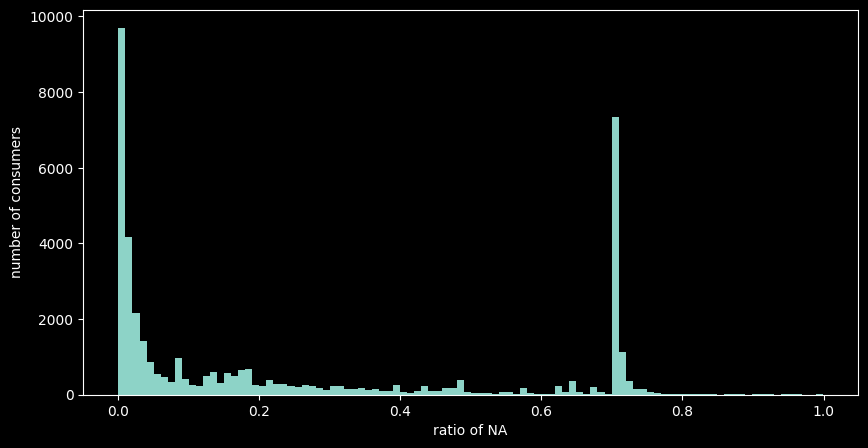

In [6]:
# Display histogram of the number of nulls in each row (across all columns)
na_ratio = df.isnull().sum(axis=1) / df.shape[1]
na_ratio.plot(kind='hist', xlabel='ratio of NA', ylabel='number of consumers', bins=100, figsize=(10, 5))


In [7]:
# Firstly, remove rows with more than 35 percent missing values
df = df[(df.isnull().sum(axis=1) / df.shape[1]) < 0.35]
print(df.shape)

(28949, 1035)


In [8]:
# check the customers with all 0 values
df[df.iloc[:, :-1].sum(axis=1) == 0.0]

,FLAG,2014/1/1,2014/1/10,2014/1/11,2014/1/12,2014/1/13,2014/1/14,2014/1/15,2014/1/16,2014/1/17,...,2016/9/28,2016/9/29,2016/9/3,2016/9/30,2016/9/4,2016/9/5,2016/9/6,2016/9/7,2016/9/8,2016/9/9
CONS_NO,,,,,,,,,,,,,,,,,,,,,
B6E8F3547A23BF3F899ABEF08398EEF5,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
680F35B3C0CB971083F4A8B543309FBB,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2920EB014F35BC4248F7255C85733472,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
170537BAB9401C55116B6870089FDBF3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2CD0C1DC94E45E309324026357CACD4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1072F101CD47D7DDA7DC42106617C456,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02D6FDF81EB86DD6EBE24E19C6F383E5,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B99ED8A0093A11E875B6E5D538A4DB78,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: xlabel='ratio of zero values', ylabel='number of consumers'>

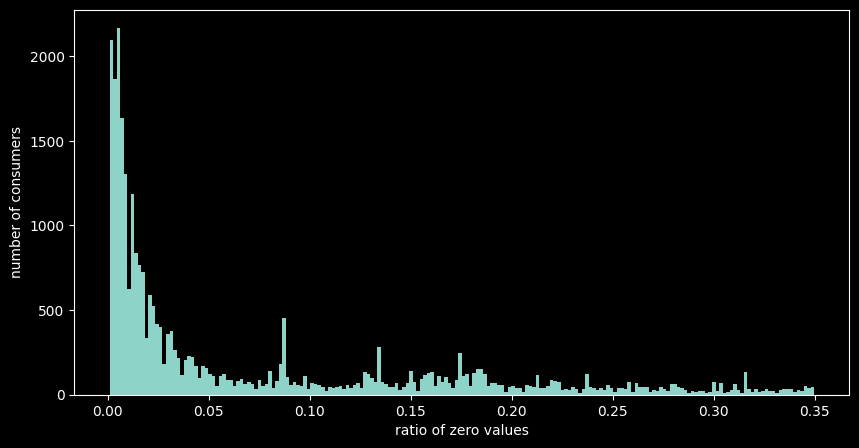

In [9]:
# Display histogram of the number of 0 values in each row (across all columns)
zero_ratio = df.isnull().sum(axis=1) / df.shape[1]
zero_ratio.plot(kind='hist', xlabel='ratio of zero values', ylabel='number of consumers', bins=200, figsize=(10, 5))

In [10]:
# Remove rows with more than 35 percent zero values (including nulls)
df = df[df.iloc[:, :-1].eq(0).sum(axis=1) / df.shape[1] < 0.35]
print(df.shape)

(23595, 1035)


In [11]:
# Check the ratio of 'FLAG' after cleansing
print(df['FLAG'].sum())
print(df['FLAG'].sum() / df.shape[0])

1911
0.08099173553719008


In [12]:
df_flag = df['FLAG']
df = df.drop(['FLAG'], axis=1)
df_flag

CONS_NO
EDFC78B07BA2908B3395C4EB2304665E    1
34C1954AA3703C4F8BD8EAEA7C4B7B83    1
768309B0EB11FD436CEE5ABFB84F4C0C    1
516954F5FF177CE314656D727FCC66A5    1
E34D1B467A365835A4A8AAD9395D49AA    1
                                   ..
5FCE503B6B616D5023B3C46173383107    0
F1472871E1AFF49D4289564B6377D76C    0
F3C8BBCD2DC26C1E0249DEEF6A4256B7    0
A9A0FE83467A680FBFB0DBFC910DF227    0
D9A6ADA018FA46A55D5438370456AA45    0
Name: FLAG, Length: 23595, dtype: int64

In [13]:
df = df.T

In [14]:
df.index = pd.to_datetime(df.index)

In [15]:
df

CONS_NO,EDFC78B07BA2908B3395C4EB2304665E,34C1954AA3703C4F8BD8EAEA7C4B7B83,768309B0EB11FD436CEE5ABFB84F4C0C,516954F5FF177CE314656D727FCC66A5,E34D1B467A365835A4A8AAD9395D49AA,9F61C13255D1183B179753742A24BFAD,F1D26619E4BC428924BAF5261F705D18,E89F2AD4B103F2E2045EE0F4E60429BC,441D4A577AAD02F6C003644640C2619C,A9601F29D6AE4544F52BD5CB56426E3F,...,2A32029199A137504FB925D214AF20E9,1C6A4E84B6CE1105A01EECC4955FE4AC,9B3DC5E19AC7BE97FBE1A65F4A115CC4,1DF750822A991C356E86556CF5A64955,8C864A692CC5840072CF3BEBDA3CA8DB,5FCE503B6B616D5023B3C46173383107,F1472871E1AFF49D4289564B6377D76C,F3C8BBCD2DC26C1E0249DEEF6A4256B7,A9A0FE83467A680FBFB0DBFC910DF227,D9A6ADA018FA46A55D5438370456AA45
2014-01-01,2.90,0.11,0.91,11.02,NaN,1.91,5.20,6.03,19.92,9.52,...,NaN,NaN,148.40,0.00,5.22,NaN,NaN,2.70,0.58,16.89
2014-01-10,3.42,0.53,0.86,8.24,NaN,1.82,8.03,7.29,0.00,11.68,...,NaN,NaN,174.02,0.00,0.00,NaN,NaN,4.39,0.84,13.84
2014-01-11,3.81,0.45,1.10,7.94,NaN,1.07,8.11,4.86,0.00,14.09,...,NaN,NaN,122.26,0.00,15.96,NaN,NaN,3.95,1.61,13.50
2014-01-12,4.58,0.51,0.66,7.92,NaN,1.33,2.47,8.85,12.68,12.56,...,NaN,NaN,133.16,0.00,14.53,NaN,NaN,0.00,0.90,14.60
2014-01-13,3.56,1.32,5.82,8.31,NaN,1.97,1.51,5.73,15.48,11.71,...,NaN,NaN,173.65,0.00,15.43,NaN,NaN,0.00,0.60,14.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-09-05,14.68,1.36,4.61,108.69,5.81,15.18,15.56,12.25,13.54,15.04,...,3.92,13.08,283.51,1.83,4.75,1.29,3.77,4.58,4.28,18.11
2016-09-06,16.35,0.56,3.13,87.88,4.61,21.83,15.82,1.33,13.25,10.52,...,2.99,10.90,303.76,1.39,6.94,0.67,3.96,3.33,3.37,19.31
2016-09-07,18.14,1.02,3.10,86.36,4.78,24.30,14.67,0.08,14.18,10.54,...,5.00,11.57,285.34,7.50,4.55,0.76,3.64,3.19,6.67,17.48
2016-09-08,18.41,1.96,3.74,81.51,4.21,11.58,17.46,0.15,12.92,8.55,...,6.12,10.90,282.57,4.40,6.12,1.16,3.40,4.57,2.44,17.20


In [16]:
df = df.sort_index()
df

CONS_NO,EDFC78B07BA2908B3395C4EB2304665E,34C1954AA3703C4F8BD8EAEA7C4B7B83,768309B0EB11FD436CEE5ABFB84F4C0C,516954F5FF177CE314656D727FCC66A5,E34D1B467A365835A4A8AAD9395D49AA,9F61C13255D1183B179753742A24BFAD,F1D26619E4BC428924BAF5261F705D18,E89F2AD4B103F2E2045EE0F4E60429BC,441D4A577AAD02F6C003644640C2619C,A9601F29D6AE4544F52BD5CB56426E3F,...,2A32029199A137504FB925D214AF20E9,1C6A4E84B6CE1105A01EECC4955FE4AC,9B3DC5E19AC7BE97FBE1A65F4A115CC4,1DF750822A991C356E86556CF5A64955,8C864A692CC5840072CF3BEBDA3CA8DB,5FCE503B6B616D5023B3C46173383107,F1472871E1AFF49D4289564B6377D76C,F3C8BBCD2DC26C1E0249DEEF6A4256B7,A9A0FE83467A680FBFB0DBFC910DF227,D9A6ADA018FA46A55D5438370456AA45
2014-01-01,2.90,0.11,0.91,11.02,NaN,1.91,5.20,6.03,19.92,9.52,...,NaN,NaN,148.40,0.00,5.22,NaN,NaN,2.70,0.58,16.89
2014-01-02,5.64,0.11,1.16,7.92,NaN,2.11,2.35,3.18,14.81,9.36,...,NaN,NaN,159.86,0.00,5.04,NaN,NaN,0.00,1.16,15.15
2014-01-03,6.99,0.25,0.75,8.41,NaN,1.69,2.56,3.33,13.11,11.21,...,NaN,NaN,157.20,0.00,4.92,NaN,NaN,0.00,0.92,19.28
2014-01-04,3.32,0.27,1.30,9.66,NaN,1.72,1.46,7.26,14.51,13.45,...,NaN,NaN,104.80,0.00,4.88,NaN,NaN,5.72,0.98,17.19
2014-01-05,3.61,0.21,0.74,9.86,NaN,1.31,2.04,6.36,15.43,12.20,...,NaN,NaN,118.17,0.00,13.59,NaN,NaN,6.05,1.54,16.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-10-27,6.73,1.18,3.82,57.22,4.59,12.22,15.89,0.00,11.65,9.68,...,8.60,11.85,236.22,2.50,6.78,0.82,2.83,4.64,0.51,11.15
2016-10-28,7.52,1.13,2.75,56.68,4.71,16.39,13.00,0.26,10.96,8.95,...,4.23,11.46,243.06,2.74,7.83,0.65,2.54,3.71,0.79,12.22
2016-10-29,10.89,1.34,2.96,45.28,5.62,12.14,14.80,0.45,13.34,8.51,...,3.54,8.98,114.47,4.55,14.42,0.53,3.40,6.22,0.66,13.16
2016-10-30,9.86,1.26,3.67,44.04,6.83,10.82,14.91,0.36,9.91,8.40,...,3.26,9.95,115.52,3.76,9.58,0.77,3.59,6.05,0.39,13.33


In [17]:
# interpolate residual null values
df.interpolate(limit_direction="both",inplace=True)

In [18]:
# check null values again
df.isnull().sum()

CONS_NO
EDFC78B07BA2908B3395C4EB2304665E    0
34C1954AA3703C4F8BD8EAEA7C4B7B83    0
768309B0EB11FD436CEE5ABFB84F4C0C    0
516954F5FF177CE314656D727FCC66A5    0
E34D1B467A365835A4A8AAD9395D49AA    0
                                   ..
5FCE503B6B616D5023B3C46173383107    0
F1472871E1AFF49D4289564B6377D76C    0
F3C8BBCD2DC26C1E0249DEEF6A4256B7    0
A9A0FE83467A680FBFB0DBFC910DF227    0
D9A6ADA018FA46A55D5438370456AA45    0
Length: 23595, dtype: int64

In [19]:
df = df.T
df

,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
CONS_NO,,,,,,,,,,,,,,,,,,,,,
EDFC78B07BA2908B3395C4EB2304665E,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
34C1954AA3703C4F8BD8EAEA7C4B7B83,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,0.23,0.53,...,1.85,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40
768309B0EB11FD436CEE5ABFB84F4C0C,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,1.17,0.86,...,3.55,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91
516954F5FF177CE314656D727FCC66A5,11.02,7.92,8.41,9.66,9.86,8.32,8.21,7.88,10.17,8.24,...,64.11,84.89,60.86,52.67,49.43,57.22,56.68,45.28,44.04,43.36
E34D1B467A365835A4A8AAD9395D49AA,19.21,19.21,19.21,19.21,19.21,19.21,19.21,19.21,19.21,19.21,...,6.27,6.47,3.99,5.03,5.28,4.59,4.71,5.62,6.83,4.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5FCE503B6B616D5023B3C46173383107,1.95,1.95,1.95,1.95,1.95,1.95,1.95,1.95,1.95,1.95,...,0.59,0.95,0.39,0.86,0.60,0.82,0.65,0.53,0.77,0.56
F1472871E1AFF49D4289564B6377D76C,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,...,3.27,3.10,2.75,3.01,2.99,2.83,2.54,3.40,3.59,2.54
F3C8BBCD2DC26C1E0249DEEF6A4256B7,2.70,0.00,0.00,5.72,6.05,5.81,3.07,4.04,5.68,4.39,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77


In [20]:
df_all = pd.DataFrame.merge(df, df_flag, left_index=True, right_index=True)

### Under sampling

In [21]:
df_theft = df_all[df_all['FLAG'] == 1]
df_normal = df_all[df_all['FLAG'] == 0]

# Random sampling from df_normal with same size to df_theft for balancing
df_normal = df_normal.sample(n=df_theft.shape[0])

df_all = pd.concat([df_normal, df_theft])
df_all

,2014-01-01 00:00:00,2014-01-02 00:00:00,2014-01-03 00:00:00,2014-01-04 00:00:00,2014-01-05 00:00:00,2014-01-06 00:00:00,2014-01-07 00:00:00,2014-01-08 00:00:00,2014-01-09 00:00:00,2014-01-10 00:00:00,...,2016-10-23 00:00:00,2016-10-24 00:00:00,2016-10-25 00:00:00,2016-10-26 00:00:00,2016-10-27 00:00:00,2016-10-28 00:00:00,2016-10-29 00:00:00,2016-10-30 00:00:00,2016-10-31 00:00:00,FLAG
CONS_NO,,,,,,,,,,,,,,,,,,,,,
2D848D383200BEDCD2C4AA929377127B,9.82,9.82,9.82,9.82,9.82,9.82,9.82,9.82,9.82,9.82,...,28.71,24.17,26.20,30.65,27.25,31.70,25.16,20.52,22.23,0
4B6FD5671FBF97E616401E20974D3ECE,0.00,1.66,0.00,0.00,0.00,0.00,0.00,0.00,1.68,0.91,...,3.47,4.27,3.08,3.46,4.33,3.70,3.59,5.08,3.71,0
52E87EE4D3BE2A226D5D469F44C75215,12.93,12.99,10.51,11.93,10.17,12.29,13.43,9.70,25.92,33.93,...,16.40,13.37,12.12,13.92,13.75,15.21,12.96,11.80,12.26,0
93DB098BB5DC6549D26446C3E23ACC1F,4.74,7.04,7.18,7.71,11.14,10.86,8.27,10.06,8.14,8.58,...,2.04,1.79,2.15,2.33,2.70,2.08,1.85,3.16,2.11,0
4BED8479B9E9EF8362D4B06E326E1760,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,6.15,4.99,4.12,4.99,3.98,5.91,3.19,2.51,5.23,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41715691C8776A821E7656C05BC7326B,1.36,1.36,1.36,1.36,1.36,1.36,1.36,1.36,1.36,1.36,...,10.43,9.23,10.88,8.03,9.48,10.67,12.65,11.12,9.56,1
B7C5E0F9B8C258C21E4B925E67779313,37.67,46.66,37.28,41.33,38.91,31.15,66.65,32.01,36.85,94.06,...,0.63,0.62,0.61,0.62,0.61,0.61,0.60,0.60,0.59,1
B4998F95CB5A8A53C79C999C7179D00C,2.87,3.71,4.50,3.81,3.63,4.62,3.66,3.80,10.07,11.63,...,3.06,1.84,1.38,1.78,1.71,1.99,2.20,2.13,1.88,1


In [22]:
# Normalize data between 0 and 1
df_flag = df_all['FLAG']
df_all_scaled = df_all.div(df_all.max(axis=1), axis=0)
df_all_scaled['FLAG'] = df_flag
df_all_scaled

,2014-01-01 00:00:00,2014-01-02 00:00:00,2014-01-03 00:00:00,2014-01-04 00:00:00,2014-01-05 00:00:00,2014-01-06 00:00:00,2014-01-07 00:00:00,2014-01-08 00:00:00,2014-01-09 00:00:00,2014-01-10 00:00:00,...,2016-10-23 00:00:00,2016-10-24 00:00:00,2016-10-25 00:00:00,2016-10-26 00:00:00,2016-10-27 00:00:00,2016-10-28 00:00:00,2016-10-29 00:00:00,2016-10-30 00:00:00,2016-10-31 00:00:00,FLAG
CONS_NO,,,,,,,,,,,,,,,,,,,,,
2D848D383200BEDCD2C4AA929377127B,0.186586,0.186586,0.186586,0.186586,0.186586,0.186586,0.186586,0.186586,0.186586,0.186586,...,0.545506,0.459244,0.497815,0.582367,0.517766,0.602318,0.478054,0.389892,0.422383,0
4B6FD5671FBF97E616401E20974D3ECE,0.000000,0.088628,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.089696,0.048585,...,0.185264,0.227977,0.164442,0.184730,0.231180,0.197544,0.191671,0.271223,0.198078,0
52E87EE4D3BE2A226D5D469F44C75215,0.188842,0.189718,0.153498,0.174237,0.148532,0.179495,0.196144,0.141668,0.378560,0.495545,...,0.239521,0.195268,0.177012,0.203301,0.200818,0.222141,0.189280,0.172338,0.179057,0
93DB098BB5DC6549D26446C3E23ACC1F,0.235821,0.350249,0.357214,0.383582,0.554229,0.540299,0.411443,0.500498,0.404975,0.426866,...,0.101493,0.089055,0.106965,0.115920,0.134328,0.103483,0.092040,0.157214,0.104975,0
4BED8479B9E9EF8362D4B06E326E1760,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.239021,0.193937,0.160124,0.193937,0.154683,0.229693,0.123980,0.097551,0.203265,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41715691C8776A821E7656C05BC7326B,0.015779,0.015779,0.015779,0.015779,0.015779,0.015779,0.015779,0.015779,0.015779,0.015779,...,0.121012,0.107089,0.126233,0.093166,0.109990,0.123796,0.146769,0.129017,0.110918,1
B7C5E0F9B8C258C21E4B925E67779313,0.267524,0.331369,0.264754,0.293516,0.276330,0.221220,0.473333,0.227328,0.261700,0.667992,...,0.004474,0.004403,0.004332,0.004403,0.004332,0.004332,0.004261,0.004261,0.004190,1
B4998F95CB5A8A53C79C999C7179D00C,0.064494,0.083371,0.101124,0.085618,0.081573,0.103820,0.082247,0.085393,0.226292,0.261348,...,0.068764,0.041348,0.031011,0.040000,0.038427,0.044719,0.049438,0.047865,0.042247,1


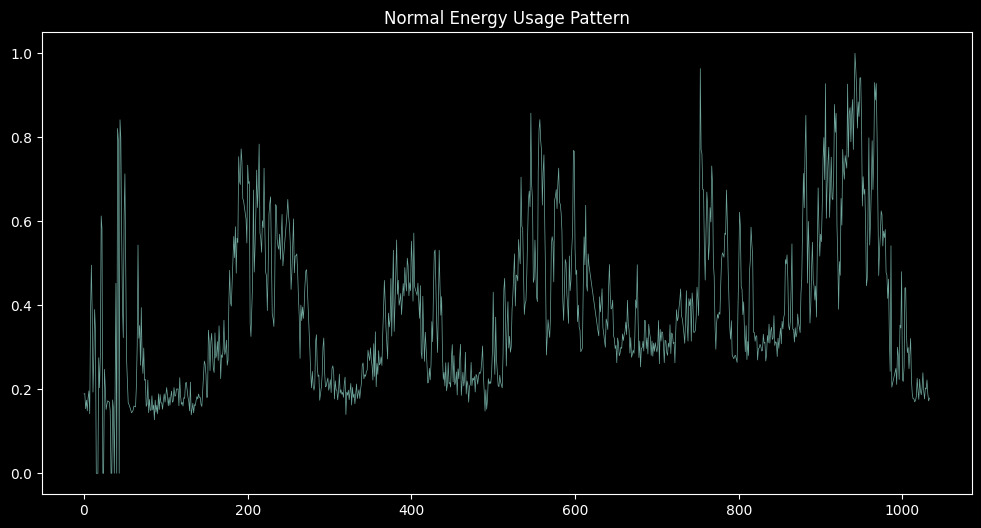

In [23]:
plt.grid()

for i in range(2,3):
    plt.plot(range(df_all_scaled.shape[1]-1), df_all_scaled[df_all_scaled['FLAG']==0].iloc[i,:-1], linewidth=0.5, alpha=0.8)

plt.gca().patch.set_facecolor('black') 
plt.title("Normal Energy Usage Pattern")
plt.grid(False)
# set size
plt.gcf().set_size_inches(12,6)
# background white
plt.show()

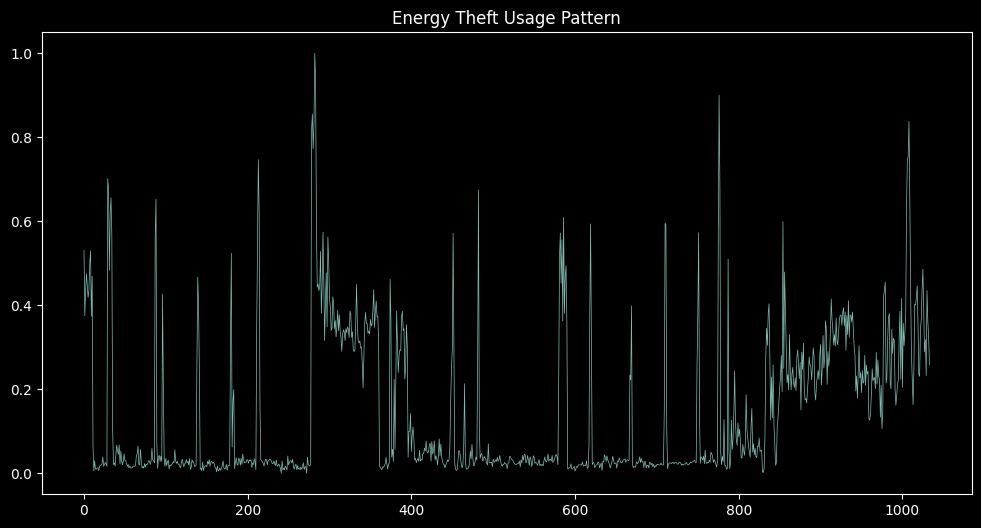

In [24]:
plt.grid()
for i in range(17,18):
    plt.plot(range(df_all_scaled.shape[1]-1), df_all_scaled[df_all_scaled['FLAG']==1].iloc[i,:-1], linewidth=0.5, alpha=0.9)

plt.gca().patch.set_facecolor('black') 
plt.title("Energy Theft Usage Pattern")
plt.gcf().set_size_inches(12,6)
plt.grid(False)
plt.show()

In [25]:
del df, df_flag, df_theft, df_normal, df_all

In [26]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from pyts.image import GramianAngularField
from pyts.image import MarkovTransitionField
from torchvision.transforms.functional import to_pil_image
from torchvision.transforms.functional import to_tensor
from torchvision.transforms.functional import to_grayscale

gaf = GramianAngularField(method='summation', image_size=224, sample_range=(-1,1))
gas = GramianAngularField(method='difference', image_size=224, sample_range=(-1,1))
mtf = MarkovTransitionField(image_size=224, n_bins = 2)

total = len(df_all_scaled)

dataset = []

for i in tqdm(range(total)):
    df_gaf = gaf.fit_transform(df_all_scaled.iloc[i:i+1,:-1]).astype('float32')
    df_gas = gas.fit_transform(df_all_scaled.iloc[i:i+1,:-1]).astype('float32')
    df_mtf = mtf.fit_transform(df_all_scaled.iloc[i:i+1,:-1]).astype('float32')

    dataset.append((df_gaf, df_gas, df_mtf, df_all_scaled.iloc[i:i+1,-1:]))

100%|██████████| 3822/3822 [03:22<00:00, 18.86it/s]


C:\Users\kkomo\AppData\Local\Temp\ipykernel_22436\2951815641.py:8: MatplotlibDeprecationWarning: The toggle_label function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use ax.tick_params and colorbar.set_label instead.
  ax.cax.toggle_label(True)


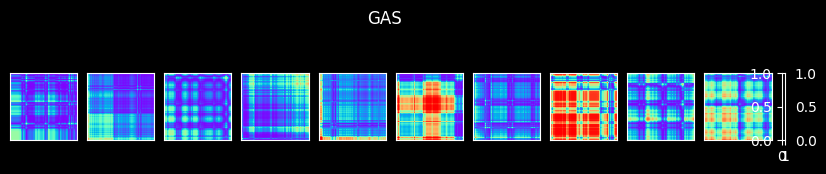

C:\Users\kkomo\AppData\Local\Temp\ipykernel_22436\2951815641.py:20: MatplotlibDeprecationWarning: The toggle_label function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use ax.tick_params and colorbar.set_label instead.
  ax.cax.toggle_label(True)


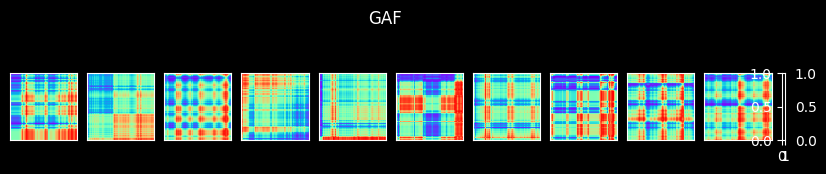

C:\Users\kkomo\AppData\Local\Temp\ipykernel_22436\2951815641.py:32: MatplotlibDeprecationWarning: The toggle_label function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use ax.tick_params and colorbar.set_label instead.
  ax.cax.toggle_label(True)


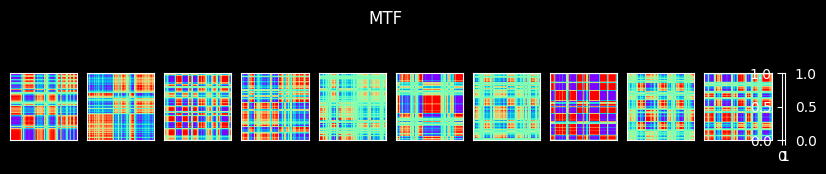

In [27]:
fig = plt.figure(figsize=(10, 2))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 10), axes_pad=0.1, cbar_mode='single', share_all=True)
for i, ax in enumerate(grid):
    im = ax.imshow(dataset[i][0][0], cmap='rainbow', origin='lower')    
grid[0].get_yaxis().set_ticks([])
grid[0].get_xaxis().set_ticks([])
# plt.colorbar(im, cax=grid.cbar_axes[0])
ax.cax.toggle_label(True)
fig.suptitle("GAS")
plt.show()


fig = plt.figure(figsize=(10, 2))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 10), axes_pad=0.1, cbar_mode='single', share_all=True)
for i, ax in enumerate(grid):
    im = ax.imshow(dataset[i][1][0], cmap='rainbow', origin='lower')    
grid[0].get_yaxis().set_ticks([])
grid[0].get_xaxis().set_ticks([])
# plt.colorbar(im, cax=grid.cbar_axes[0])
ax.cax.toggle_label(True)
fig.suptitle("GAF")
plt.show()


fig = plt.figure(figsize=(10, 2))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 10), axes_pad=0.1, cbar_mode='single', share_all=True)
for i, ax in enumerate(grid):
    im = ax.imshow(dataset[i][2][0], cmap='rainbow', origin='lower')    
grid[0].get_yaxis().set_ticks([])
grid[0].get_xaxis().set_ticks([])
# plt.colorbar(im, cax=grid.cbar_axes[0])
ax.cax.toggle_label(True)
fig.suptitle("MTF")
plt.show()


In [28]:
# split train, test dataset with 8:2 unsing normal random splitter of pytorch
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size

splitter = torch.utils.data.random_split(dataset, [train_size, test_size])
train_dataset = splitter[0]
test_dataset = splitter[1]

# split train, validation dataset with 8:2 unsing normal random splitter of pytorch
train_size = int(len(train_dataset) * 0.8)
val_size = len(train_dataset) - train_size
splitter = torch.utils.data.random_split(train_dataset, [train_size, val_size])
train_dataset = splitter[0]
val_dataset = splitter[1]

print("size (train, val, test) = ({}, {}, {})".format( len(train_dataset), len(val_dataset), len(test_dataset))) 

size (train, val, test) = (2445, 612, 765)


In [29]:
# Creating the dataset class
class EnergyData(Dataset):
    def __init__(self, datalist):
        listx = []
        listy = []
        for i in datalist:
            # listx.append(torch.cat([i[0], i[1], i[2]]))
            listx.append(np.vstack((i[0], i[1], i[2])))
            
            if i[3].values == 0:
                y = torch.tensor([1,0])
                listy.append(y.float())
                # print('yes', y)
            else:
                y = torch.tensor([0,1])
                listy.append(y.float())
                # print('else', y)
            
            # listy.append(torch.unsqueeze(torch.tensor(i[1]).float(), dim=0))           
            
        self.x = listx
        self.y = listy
        self.len = len(datalist)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.len


tr = EnergyData(train_dataset)
val = EnergyData(val_dataset)
ts = EnergyData(test_dataset)

del dataset

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device)) 

torch.manual_seed(45)
torch.cuda.manual_seed_all(45)

Using cuda device


In [31]:
def print_losses(train_counter, train_losses, val_counter, val_losses, weight_decay, lr_rate):
    fig = plt.figure()
    plt.plot(train_counter, train_losses, label='Training Loss')
    plt.scatter(val_counter, val_losses, label='Validation Loss', color='red')
    plt.legend(['Training loss','Validation loss'], loc='upper right')
    plt.title('Training and Validation Loss(weight_decay = {}, lr = {})'.format(weight_decay, lr_rate))
    plt.ylabel('Cross Entropy Loss')
    fig.show()

In [33]:
def train(model, tr_data, val_data, batch_size, lr_rate = 0.001, moment = 0.9, weight_dec = 0.08, num_of_epoch=10, logging_period=4):
    
    res_loss = {}
    
    class_weights = torch.Tensor([0.5, 0.5]).to(device)

    # model =  models.vgg16(pretrained=True)
    # model.classifier[6] = nn.Sequential(
    #     nn.Linear(in_features = model.classifier[6].in_features, out_features = 2, bias = True),
    #     nn.Softmax(dim=1)
    # )

    for param in model.parameters():   
        param.requires_grad = False
    for param in model.classifier.parameters():
        param.requires_grad = True
    

    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss(weight = class_weights)
    # optimizer = optim.Adam(model.parameters(), lr=lr_rate, weight_decay=weight_dec)
    optimizer =  optim.SGD(model.parameters(), lr=lr_rate, momentum=moment, weight_decay=weight_dec)

    train_losses = []
    train_accuracy = []
    val_losses = []
    val_accuracy = []

    # List for plotting X-axis
    train_counter = []
    val_counter = []

    r_seed = 42

    trainloader = DataLoader(tr_data, batch_size=batch_size, shuffle=True)
    valloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    
    model.train()

    for epoch in tqdm(range(num_of_epoch), total=num_of_epoch):  # loop over the dataset multiple times

        epoch_loss = 0.0
        epoch_correct = 0    
        epoch_total = 0
        running_loss = 0.0   
        running_correct = 0 
        running_total = 0

        # if epoch == 10:
        #     lr_rate = lr_rate * 0.5
        #     optimizer =  optim.SGD(model.parameters(), lr=lr_rate, momentum=moment, weight_decay=weight_dec)

        for i, data in enumerate(trainloader):  
            
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels =  data[0].to(device), data[1].to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # inputs = transform(inputs)
            outputs = model(inputs)   

            loss = criterion(outputs, labels)        
            loss.backward()
            optimizer.step()

            sum_loss = loss.item() * len(labels)
            running_loss += sum_loss
            epoch_loss += sum_loss

            num_correct = torch.eq(torch.argmax(outputs, dim=1), torch.argmax(labels, dim=1)).int().sum().item()
            running_correct += num_correct
            epoch_correct += num_correct
            # print(torch.argmax(outputs, dim=1), ' ', torch.argmax(labels, dim=1))
            # print(torch.eq(torch.argmax(outputs, dim=1), torch.argmax(labels, dim=1)))
            # print(num_correct)
            
            # print('Every batch loss: ', loss.item())
            # print('Running loss: ', running_loss)
            # print('Epoch loss: ', epoch_loss)
            # print('Every batch correct num: ', num_correct)
            # print('Running correct: ', running_correct)
            # print('Epoch correct: ', epoch_correct)

            # print('total: {}, i = {}'.format(total, i))
            
            epoch_total = epoch_total + len(labels)
            running_total = running_total + len(labels)

            # print & accumulate training statistics (loss & accuracy) every 10 iterations
            if (i % logging_period == 0):            
                avg_running_loss = running_loss / running_total
                avg_running_accuracy = 100. * running_correct / running_total

                print('Epoch{} [{}/{} ({:.0f}%)]\t   avg.loss:{:.4f}   avg.accuracy:{:.4f}'
                    .format(epoch+1, i * len(labels), len(trainloader.dataset), 100. * i / len(trainloader), 
                            avg_running_loss, avg_running_accuracy))
                
                running_loss = 0.0   
                running_correct = 0 
                running_total = 0

                train_losses.append(avg_running_loss)
                train_accuracy.append(avg_running_accuracy)
                train_counter.append((epoch)*len(trainloader.dataset)+epoch_total)    
            

        # print & accumulate val statistics (loss & accuracy)
        print('[Epoch {}] Train Loss: {:.4f} Train Accuracy: {:.4f} w_decay:{} lr_rate:{}'.format(epoch + 1, 
                            epoch_loss / epoch_total, 100. * epoch_correct / epoch_total, weight_dec, lr_rate))

        # Validation at the end of the epoch
        # set mode to eval mode & tell torch no gradients are required.
        y_true = []
        y_pred = []

        model.eval()

        with torch.no_grad():   

            val_running_loss = 0.0
            val_correct = 0
            val_count = 0            

            # loop through the data and find accuracy and loss for all val data
            for (inputs, labels) in valloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # inputs = transform(inputs)
                outputs = model(inputs) 
                
                val_correct += torch.eq(torch.argmax(outputs, dim=1), torch.argmax(labels, dim=1)).int().sum().item()
                # print('correct=', correct)

                y_true.extend(torch.argmax(labels, dim=1).cpu().numpy())  # Move labels to CPU and convert to numpy
                y_pred.extend(torch.argmax(outputs, dim=1).cpu().numpy())   # Move preds to CPU and convert to numpy

                loss = criterion(outputs, labels) 

                val_running_loss += loss.item() * len(labels)

                val_count = val_count + len(labels)      

        val_losses.append(val_running_loss / len(valloader.dataset))
        val_accuracy.append(100. * val_correct / len(valloader.dataset))
        val_counter.append((epoch+1) * len(trainloader.dataset))

        print('\nValidation set: avg.loss: {:.4f},   avg.accuracy: {}/{} ({:.4f}%)\n'.format(
        val_running_loss / len(valloader.dataset), val_correct, len(valloader.dataset), 100. * val_correct / len(valloader.dataset)))

        # Print F1 score
        rec_score = recall_score(y_true, y_pred)
        print('Recall: {:.6f}'.format(rec_score))

        pre_score = precision_score(y_true, y_pred)
        print('Precision: {:.6f}'.format(pre_score))

        f1 = f1_score(y_true, y_pred)
        print('F1 Score: {:.6f}'.format(f1))

        acc_score = accuracy_score(y_true, y_pred)
        print('Accuracy: {:.6f}'.format(acc_score))
        

        # set the model back to train mode
        model.train()

    # print('Finished Training')
    print_losses(train_counter, train_losses, val_counter, val_losses, weight_dec, lr_rate)

    res_loss[weight_dec] = val_running_loss / len(valloader.dataset)

    return f1


In [34]:
def test(model, ts, batch_size):

    y_true = []
    y_pred = []

    model.eval()

    with torch.no_grad():
        
        test_correct = 0

        testloader = DataLoader(ts, batch_size=batch_size)

        for (inputs, labels) in testloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # inputs = transform(inputs)       
            outputs = model(inputs)
            
            test_correct += torch.eq(torch.argmax(outputs, dim=1), torch.argmax(labels, dim=1)).int().sum().item()

            y_true.extend(torch.argmax(labels, dim=1).cpu().numpy())  # Move labels to CPU and convert to numpy
            y_pred.extend(torch.argmax(outputs, dim=1).cpu().numpy())   # Move preds to CPU and convert to numpy
                        
            accuracy_test = 100. * test_correct / len(testloader.dataset)

        # print('Test accuracy: {:.4f} ({}/{})'.format(accuracy_test, accuracy_test, len(testloader.dataset)))


        # plot confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6,6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.show()

        # Print F1 score
        rec_score = recall_score(y_true, y_pred)
        print('Recall: {:.4f}'.format(rec_score))

        pre_score = precision_score(y_true, y_pred)
        print('Precision: {:.4f}'.format(pre_score))

        f1 = f1_score(y_true, y_pred)
        print('F1 Score: {:.4f}'.format(f1))

        acc_score = accuracy_score(y_true, y_pred)
        print('Accuracy: {:.4f}'.format(acc_score))
    
    model.train()

    return

c:\Users\kkomo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kkomo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


===================  Weight decay = 0.08, lr = 0.0005 ===================


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch1 [0/2445 (0%)]	   avg.loss:0.3632   avg.accuracy:37.5000
Epoch1 [128/2445 (5%)]	   avg.loss:0.3462   avg.accuracy:53.9062
Epoch1 [256/2445 (10%)]	   avg.loss:0.3479   avg.accuracy:50.0000
Epoch1 [384/2445 (16%)]	   avg.loss:0.3494   avg.accuracy:55.4688
Epoch1 [512/2445 (21%)]	   avg.loss:0.3532   avg.accuracy:45.3125
Epoch1 [640/2445 (26%)]	   avg.loss:0.3487   avg.accuracy:47.6562
Epoch1 [768/2445 (31%)]	   avg.loss:0.3469   avg.accuracy:49.2188
Epoch1 [896/2445 (36%)]	   avg.loss:0.3453   avg.accuracy:49.2188
Epoch1 [1024/2445 (42%)]	   avg.loss:0.3506   avg.accuracy:50.0000
Epoch1 [1152/2445 (47%)]	   avg.loss:0.3419   avg.accuracy:61.7188
Epoch1 [1280/2445 (52%)]	   avg.loss:0.3418   avg.accuracy:53.1250
Epoch1 [1408/2445 (57%)]	   avg.loss:0.3542   avg.accuracy:42.1875
Epoch1 [1536/2445 (62%)]	   avg.loss:0.3514   avg.accuracy:53.9062
Epoch1 [1664/2445 (68%)]	   avg.loss:0.3429   avg.accuracy:49.2188
Epoch1 [1792/2445 (73%)]	   avg.loss:0.3464   avg.accuracy:52.3438
Epoch1 

  7%|▋         | 1/15 [00:18<04:17, 18.42s/it]


Validation set: avg.loss: 0.3339,   avg.accuracy: 391/612 (63.8889%)

Recall: 0.641115
Precision: 0.609272
F1 Score: 0.624788
Accuracy: 0.638889
Epoch2 [0/2445 (0%)]	   avg.loss:0.3235   avg.accuracy:65.6250
Epoch2 [128/2445 (5%)]	   avg.loss:0.3403   avg.accuracy:60.9375
Epoch2 [256/2445 (10%)]	   avg.loss:0.3437   avg.accuracy:53.1250
Epoch2 [384/2445 (16%)]	   avg.loss:0.3329   avg.accuracy:63.2812
Epoch2 [512/2445 (21%)]	   avg.loss:0.3373   avg.accuracy:57.8125
Epoch2 [640/2445 (26%)]	   avg.loss:0.3434   avg.accuracy:52.3438
Epoch2 [768/2445 (31%)]	   avg.loss:0.3319   avg.accuracy:64.0625
Epoch2 [896/2445 (36%)]	   avg.loss:0.3417   avg.accuracy:53.1250
Epoch2 [1024/2445 (42%)]	   avg.loss:0.3431   avg.accuracy:53.1250
Epoch2 [1152/2445 (47%)]	   avg.loss:0.3328   avg.accuracy:58.5938
Epoch2 [1280/2445 (52%)]	   avg.loss:0.3378   avg.accuracy:55.4688
Epoch2 [1408/2445 (57%)]	   avg.loss:0.3323   avg.accuracy:64.0625
Epoch2 [1536/2445 (62%)]	   avg.loss:0.3241   avg.accuracy:65.

 13%|█▎        | 2/15 [00:35<03:48, 17.54s/it]


Validation set: avg.loss: 0.3286,   avg.accuracy: 391/612 (63.8889%)

Recall: 0.731707
Precision: 0.593220
F1 Score: 0.655226
Accuracy: 0.638889
Epoch3 [0/2445 (0%)]	   avg.loss:0.3297   avg.accuracy:65.6250
Epoch3 [128/2445 (5%)]	   avg.loss:0.3358   avg.accuracy:57.8125
Epoch3 [256/2445 (10%)]	   avg.loss:0.3339   avg.accuracy:62.5000
Epoch3 [384/2445 (16%)]	   avg.loss:0.3296   avg.accuracy:64.0625
Epoch3 [512/2445 (21%)]	   avg.loss:0.3187   avg.accuracy:70.3125
Epoch3 [640/2445 (26%)]	   avg.loss:0.3396   avg.accuracy:61.7188
Epoch3 [768/2445 (31%)]	   avg.loss:0.3360   avg.accuracy:60.9375
Epoch3 [896/2445 (36%)]	   avg.loss:0.3457   avg.accuracy:53.9062
Epoch3 [1024/2445 (42%)]	   avg.loss:0.3362   avg.accuracy:60.9375
Epoch3 [1152/2445 (47%)]	   avg.loss:0.3375   avg.accuracy:59.3750
Epoch3 [1280/2445 (52%)]	   avg.loss:0.3319   avg.accuracy:64.0625
Epoch3 [1408/2445 (57%)]	   avg.loss:0.3394   avg.accuracy:53.9062
Epoch3 [1536/2445 (62%)]	   avg.loss:0.3344   avg.accuracy:59.

 20%|██        | 3/15 [00:52<03:27, 17.30s/it]


Validation set: avg.loss: 0.3249,   avg.accuracy: 404/612 (66.0131%)

Recall: 0.703833
Precision: 0.621538
F1 Score: 0.660131
Accuracy: 0.660131
Epoch4 [0/2445 (0%)]	   avg.loss:0.3395   avg.accuracy:59.3750
Epoch4 [128/2445 (5%)]	   avg.loss:0.3273   avg.accuracy:64.0625
Epoch4 [256/2445 (10%)]	   avg.loss:0.3424   avg.accuracy:57.0312
Epoch4 [384/2445 (16%)]	   avg.loss:0.3347   avg.accuracy:61.7188
Epoch4 [512/2445 (21%)]	   avg.loss:0.3367   avg.accuracy:62.5000
Epoch4 [640/2445 (26%)]	   avg.loss:0.3198   avg.accuracy:67.1875
Epoch4 [768/2445 (31%)]	   avg.loss:0.3402   avg.accuracy:57.8125
Epoch4 [896/2445 (36%)]	   avg.loss:0.3310   avg.accuracy:63.2812
Epoch4 [1024/2445 (42%)]	   avg.loss:0.3379   avg.accuracy:59.3750
Epoch4 [1152/2445 (47%)]	   avg.loss:0.3487   avg.accuracy:53.9062
Epoch4 [1280/2445 (52%)]	   avg.loss:0.3398   avg.accuracy:57.0312
Epoch4 [1408/2445 (57%)]	   avg.loss:0.3204   avg.accuracy:66.4062
Epoch4 [1536/2445 (62%)]	   avg.loss:0.3199   avg.accuracy:66.

 27%|██▋       | 4/15 [01:09<03:09, 17.20s/it]


Validation set: avg.loss: 0.3224,   avg.accuracy: 411/612 (67.1569%)

Recall: 0.644599
Precision: 0.651408
F1 Score: 0.647986
Accuracy: 0.671569
Epoch5 [0/2445 (0%)]	   avg.loss:0.3332   avg.accuracy:65.6250
Epoch5 [128/2445 (5%)]	   avg.loss:0.3368   avg.accuracy:60.9375
Epoch5 [256/2445 (10%)]	   avg.loss:0.3267   avg.accuracy:61.7188
Epoch5 [384/2445 (16%)]	   avg.loss:0.3350   avg.accuracy:59.3750
Epoch5 [512/2445 (21%)]	   avg.loss:0.3230   avg.accuracy:69.5312
Epoch5 [640/2445 (26%)]	   avg.loss:0.3223   avg.accuracy:68.7500
Epoch5 [768/2445 (31%)]	   avg.loss:0.3327   avg.accuracy:63.2812
Epoch5 [896/2445 (36%)]	   avg.loss:0.3245   avg.accuracy:65.6250
Epoch5 [1024/2445 (42%)]	   avg.loss:0.3339   avg.accuracy:59.3750
Epoch5 [1152/2445 (47%)]	   avg.loss:0.3429   avg.accuracy:55.4688
Epoch5 [1280/2445 (52%)]	   avg.loss:0.3188   avg.accuracy:66.4062
Epoch5 [1408/2445 (57%)]	   avg.loss:0.3223   avg.accuracy:64.0625
Epoch5 [1536/2445 (62%)]	   avg.loss:0.3296   avg.accuracy:61.

 33%|███▎      | 5/15 [01:26<02:50, 17.09s/it]


Validation set: avg.loss: 0.3207,   avg.accuracy: 405/612 (66.1765%)

Recall: 0.550523
Precision: 0.669492
F1 Score: 0.604207
Accuracy: 0.661765
Epoch6 [0/2445 (0%)]	   avg.loss:0.3225   avg.accuracy:53.1250
Epoch6 [128/2445 (5%)]	   avg.loss:0.3322   avg.accuracy:57.8125
Epoch6 [256/2445 (10%)]	   avg.loss:0.3345   avg.accuracy:60.9375
Epoch6 [384/2445 (16%)]	   avg.loss:0.3238   avg.accuracy:65.6250
Epoch6 [512/2445 (21%)]	   avg.loss:0.3160   avg.accuracy:67.9688
Epoch6 [640/2445 (26%)]	   avg.loss:0.3245   avg.accuracy:64.0625
Epoch6 [768/2445 (31%)]	   avg.loss:0.3220   avg.accuracy:71.8750
Epoch6 [896/2445 (36%)]	   avg.loss:0.3296   avg.accuracy:62.5000
Epoch6 [1024/2445 (42%)]	   avg.loss:0.3355   avg.accuracy:56.2500
Epoch6 [1152/2445 (47%)]	   avg.loss:0.3334   avg.accuracy:63.2812
Epoch6 [1280/2445 (52%)]	   avg.loss:0.3383   avg.accuracy:57.8125
Epoch6 [1408/2445 (57%)]	   avg.loss:0.3378   avg.accuracy:57.8125
Epoch6 [1536/2445 (62%)]	   avg.loss:0.3297   avg.accuracy:60.

 40%|████      | 6/15 [01:43<02:33, 17.00s/it]


Validation set: avg.loss: 0.3198,   avg.accuracy: 413/612 (67.4837%)

Recall: 0.689895
Precision: 0.642857
F1 Score: 0.665546
Accuracy: 0.674837
Epoch7 [0/2445 (0%)]	   avg.loss:0.3562   avg.accuracy:43.7500
Epoch7 [128/2445 (5%)]	   avg.loss:0.3163   avg.accuracy:65.6250
Epoch7 [256/2445 (10%)]	   avg.loss:0.3392   avg.accuracy:57.0312
Epoch7 [384/2445 (16%)]	   avg.loss:0.3242   avg.accuracy:61.7188
Epoch7 [512/2445 (21%)]	   avg.loss:0.3264   avg.accuracy:63.2812
Epoch7 [640/2445 (26%)]	   avg.loss:0.3324   avg.accuracy:59.3750
Epoch7 [768/2445 (31%)]	   avg.loss:0.3301   avg.accuracy:66.4062
Epoch7 [896/2445 (36%)]	   avg.loss:0.3381   avg.accuracy:54.6875
Epoch7 [1024/2445 (42%)]	   avg.loss:0.3282   avg.accuracy:61.7188
Epoch7 [1152/2445 (47%)]	   avg.loss:0.3239   avg.accuracy:63.2812
Epoch7 [1280/2445 (52%)]	   avg.loss:0.3147   avg.accuracy:67.9688
Epoch7 [1408/2445 (57%)]	   avg.loss:0.3226   avg.accuracy:70.3125
Epoch7 [1536/2445 (62%)]	   avg.loss:0.3254   avg.accuracy:61.

 47%|████▋     | 7/15 [01:59<02:15, 16.95s/it]


Validation set: avg.loss: 0.3207,   avg.accuracy: 398/612 (65.0327%)

Recall: 0.763066
Precision: 0.600000
F1 Score: 0.671779
Accuracy: 0.650327
Epoch8 [0/2445 (0%)]	   avg.loss:0.3667   avg.accuracy:46.8750
Epoch8 [128/2445 (5%)]	   avg.loss:0.3068   avg.accuracy:71.0938
Epoch8 [256/2445 (10%)]	   avg.loss:0.3272   avg.accuracy:62.5000
Epoch8 [384/2445 (16%)]	   avg.loss:0.3197   avg.accuracy:63.2812
Epoch8 [512/2445 (21%)]	   avg.loss:0.3266   avg.accuracy:62.5000
Epoch8 [640/2445 (26%)]	   avg.loss:0.3312   avg.accuracy:64.0625
Epoch8 [768/2445 (31%)]	   avg.loss:0.3159   avg.accuracy:67.9688
Epoch8 [896/2445 (36%)]	   avg.loss:0.3283   avg.accuracy:66.4062
Epoch8 [1024/2445 (42%)]	   avg.loss:0.3327   avg.accuracy:60.1562
Epoch8 [1152/2445 (47%)]	   avg.loss:0.3223   avg.accuracy:65.6250
Epoch8 [1280/2445 (52%)]	   avg.loss:0.3333   avg.accuracy:53.9062
Epoch8 [1408/2445 (57%)]	   avg.loss:0.3275   avg.accuracy:63.2812
Epoch8 [1536/2445 (62%)]	   avg.loss:0.3278   avg.accuracy:63.

 53%|█████▎    | 8/15 [02:16<01:58, 16.93s/it]


Validation set: avg.loss: 0.3185,   avg.accuracy: 408/612 (66.6667%)

Recall: 0.703833
Precision: 0.629283
F1 Score: 0.664474
Accuracy: 0.666667
Epoch9 [0/2445 (0%)]	   avg.loss:0.3222   avg.accuracy:65.6250
Epoch9 [128/2445 (5%)]	   avg.loss:0.3229   avg.accuracy:67.9688
Epoch9 [256/2445 (10%)]	   avg.loss:0.3208   avg.accuracy:69.5312
Epoch9 [384/2445 (16%)]	   avg.loss:0.3426   avg.accuracy:56.2500
Epoch9 [512/2445 (21%)]	   avg.loss:0.3168   avg.accuracy:68.7500
Epoch9 [640/2445 (26%)]	   avg.loss:0.3255   avg.accuracy:61.7188
Epoch9 [768/2445 (31%)]	   avg.loss:0.3390   avg.accuracy:58.5938
Epoch9 [896/2445 (36%)]	   avg.loss:0.3270   avg.accuracy:63.2812
Epoch9 [1024/2445 (42%)]	   avg.loss:0.3257   avg.accuracy:61.7188
Epoch9 [1152/2445 (47%)]	   avg.loss:0.3252   avg.accuracy:61.7188
Epoch9 [1280/2445 (52%)]	   avg.loss:0.3279   avg.accuracy:58.5938
Epoch9 [1408/2445 (57%)]	   avg.loss:0.3152   avg.accuracy:67.1875
Epoch9 [1536/2445 (62%)]	   avg.loss:0.3257   avg.accuracy:61.

 60%|██████    | 9/15 [02:33<01:41, 16.99s/it]


Validation set: avg.loss: 0.3182,   avg.accuracy: 410/612 (66.9935%)

Recall: 0.731707
Precision: 0.626866
F1 Score: 0.675241
Accuracy: 0.669935
Epoch10 [0/2445 (0%)]	   avg.loss:0.3187   avg.accuracy:68.7500
Epoch10 [128/2445 (5%)]	   avg.loss:0.3410   avg.accuracy:53.9062
Epoch10 [256/2445 (10%)]	   avg.loss:0.3158   avg.accuracy:67.9688
Epoch10 [384/2445 (16%)]	   avg.loss:0.3350   avg.accuracy:60.1562
Epoch10 [512/2445 (21%)]	   avg.loss:0.3276   avg.accuracy:60.9375
Epoch10 [640/2445 (26%)]	   avg.loss:0.3321   avg.accuracy:59.3750
Epoch10 [768/2445 (31%)]	   avg.loss:0.3213   avg.accuracy:64.0625
Epoch10 [896/2445 (36%)]	   avg.loss:0.3227   avg.accuracy:67.9688
Epoch10 [1024/2445 (42%)]	   avg.loss:0.3238   avg.accuracy:66.4062
Epoch10 [1152/2445 (47%)]	   avg.loss:0.3171   avg.accuracy:71.0938
Epoch10 [1280/2445 (52%)]	   avg.loss:0.3292   avg.accuracy:64.0625
Epoch10 [1408/2445 (57%)]	   avg.loss:0.3347   avg.accuracy:60.1562
Epoch10 [1536/2445 (62%)]	   avg.loss:0.3350   avg

 67%|██████▋   | 10/15 [02:50<01:24, 16.96s/it]


Validation set: avg.loss: 0.3185,   avg.accuracy: 402/612 (65.6863%)

Recall: 0.752613
Precision: 0.608451
F1 Score: 0.672897
Accuracy: 0.656863
Epoch11 [0/2445 (0%)]	   avg.loss:0.3173   avg.accuracy:59.3750
Epoch11 [128/2445 (5%)]	   avg.loss:0.3319   avg.accuracy:58.5938
Epoch11 [256/2445 (10%)]	   avg.loss:0.3166   avg.accuracy:65.6250
Epoch11 [384/2445 (16%)]	   avg.loss:0.3266   avg.accuracy:60.1562
Epoch11 [512/2445 (21%)]	   avg.loss:0.3161   avg.accuracy:69.5312
Epoch11 [640/2445 (26%)]	   avg.loss:0.3300   avg.accuracy:59.3750
Epoch11 [768/2445 (31%)]	   avg.loss:0.3329   avg.accuracy:60.9375
Epoch11 [896/2445 (36%)]	   avg.loss:0.3304   avg.accuracy:57.8125
Epoch11 [1024/2445 (42%)]	   avg.loss:0.3252   avg.accuracy:64.8438
Epoch11 [1152/2445 (47%)]	   avg.loss:0.3213   avg.accuracy:64.8438
Epoch11 [1280/2445 (52%)]	   avg.loss:0.3215   avg.accuracy:66.4062
Epoch11 [1408/2445 (57%)]	   avg.loss:0.3228   avg.accuracy:66.4062
Epoch11 [1536/2445 (62%)]	   avg.loss:0.3206   avg

 73%|███████▎  | 11/15 [03:08<01:08, 17.03s/it]


Validation set: avg.loss: 0.3161,   avg.accuracy: 410/612 (66.9935%)

Recall: 0.630662
Precision: 0.653430
F1 Score: 0.641844
Accuracy: 0.669935
Epoch12 [0/2445 (0%)]	   avg.loss:0.3298   avg.accuracy:59.3750
Epoch12 [128/2445 (5%)]	   avg.loss:0.3218   avg.accuracy:60.9375
Epoch12 [256/2445 (10%)]	   avg.loss:0.3176   avg.accuracy:64.8438
Epoch12 [384/2445 (16%)]	   avg.loss:0.3301   avg.accuracy:63.2812
Epoch12 [512/2445 (21%)]	   avg.loss:0.3168   avg.accuracy:67.9688
Epoch12 [640/2445 (26%)]	   avg.loss:0.3276   avg.accuracy:60.9375
Epoch12 [768/2445 (31%)]	   avg.loss:0.3269   avg.accuracy:66.4062
Epoch12 [896/2445 (36%)]	   avg.loss:0.3127   avg.accuracy:72.6562
Epoch12 [1024/2445 (42%)]	   avg.loss:0.3214   avg.accuracy:64.0625
Epoch12 [1152/2445 (47%)]	   avg.loss:0.3200   avg.accuracy:62.5000
Epoch12 [1280/2445 (52%)]	   avg.loss:0.3276   avg.accuracy:66.4062
Epoch12 [1408/2445 (57%)]	   avg.loss:0.3219   avg.accuracy:68.7500
Epoch12 [1536/2445 (62%)]	   avg.loss:0.3223   avg

 80%|████████  | 12/15 [03:25<00:51, 17.00s/it]


Validation set: avg.loss: 0.3169,   avg.accuracy: 411/612 (67.1569%)

Recall: 0.731707
Precision: 0.628743
F1 Score: 0.676329
Accuracy: 0.671569
Epoch13 [0/2445 (0%)]	   avg.loss:0.3470   avg.accuracy:56.2500
Epoch13 [128/2445 (5%)]	   avg.loss:0.3275   avg.accuracy:60.1562
Epoch13 [256/2445 (10%)]	   avg.loss:0.3246   avg.accuracy:64.8438
Epoch13 [384/2445 (16%)]	   avg.loss:0.3190   avg.accuracy:66.4062
Epoch13 [512/2445 (21%)]	   avg.loss:0.3316   avg.accuracy:61.7188
Epoch13 [640/2445 (26%)]	   avg.loss:0.3284   avg.accuracy:60.9375
Epoch13 [768/2445 (31%)]	   avg.loss:0.3250   avg.accuracy:67.1875
Epoch13 [896/2445 (36%)]	   avg.loss:0.3127   avg.accuracy:71.8750
Epoch13 [1024/2445 (42%)]	   avg.loss:0.3202   avg.accuracy:63.2812
Epoch13 [1152/2445 (47%)]	   avg.loss:0.3186   avg.accuracy:67.1875
Epoch13 [1280/2445 (52%)]	   avg.loss:0.3203   avg.accuracy:66.4062
Epoch13 [1408/2445 (57%)]	   avg.loss:0.3278   avg.accuracy:63.2812
Epoch13 [1536/2445 (62%)]	   avg.loss:0.3271   avg

 87%|████████▋ | 13/15 [03:41<00:33, 16.99s/it]


Validation set: avg.loss: 0.3165,   avg.accuracy: 413/612 (67.4837%)

Recall: 0.735192
Precision: 0.631737
F1 Score: 0.679549
Accuracy: 0.674837
Epoch14 [0/2445 (0%)]	   avg.loss:0.3262   avg.accuracy:62.5000
Epoch14 [128/2445 (5%)]	   avg.loss:0.3201   avg.accuracy:67.1875
Epoch14 [256/2445 (10%)]	   avg.loss:0.3110   avg.accuracy:71.0938
Epoch14 [384/2445 (16%)]	   avg.loss:0.3205   avg.accuracy:67.9688
Epoch14 [512/2445 (21%)]	   avg.loss:0.3254   avg.accuracy:63.2812
Epoch14 [640/2445 (26%)]	   avg.loss:0.3235   avg.accuracy:64.8438
Epoch14 [768/2445 (31%)]	   avg.loss:0.3213   avg.accuracy:64.8438
Epoch14 [896/2445 (36%)]	   avg.loss:0.3230   avg.accuracy:61.7188
Epoch14 [1024/2445 (42%)]	   avg.loss:0.3305   avg.accuracy:63.2812
Epoch14 [1152/2445 (47%)]	   avg.loss:0.3193   avg.accuracy:65.6250
Epoch14 [1280/2445 (52%)]	   avg.loss:0.3191   avg.accuracy:64.8438
Epoch14 [1408/2445 (57%)]	   avg.loss:0.3252   avg.accuracy:64.0625
Epoch14 [1536/2445 (62%)]	   avg.loss:0.3224   avg

 93%|█████████▎| 14/15 [03:58<00:16, 16.99s/it]


Validation set: avg.loss: 0.3165,   avg.accuracy: 414/612 (67.6471%)

Recall: 0.752613
Precision: 0.629738
F1 Score: 0.685714
Accuracy: 0.676471
Epoch15 [0/2445 (0%)]	   avg.loss:0.3029   avg.accuracy:78.1250
Epoch15 [128/2445 (5%)]	   avg.loss:0.3198   avg.accuracy:71.0938
Epoch15 [256/2445 (10%)]	   avg.loss:0.3266   avg.accuracy:62.5000
Epoch15 [384/2445 (16%)]	   avg.loss:0.3221   avg.accuracy:70.3125
Epoch15 [512/2445 (21%)]	   avg.loss:0.3228   avg.accuracy:60.1562
Epoch15 [640/2445 (26%)]	   avg.loss:0.3262   avg.accuracy:60.1562
Epoch15 [768/2445 (31%)]	   avg.loss:0.3213   avg.accuracy:64.0625
Epoch15 [896/2445 (36%)]	   avg.loss:0.3368   avg.accuracy:57.8125
Epoch15 [1024/2445 (42%)]	   avg.loss:0.3151   avg.accuracy:68.7500
Epoch15 [1152/2445 (47%)]	   avg.loss:0.3308   avg.accuracy:57.8125
Epoch15 [1280/2445 (52%)]	   avg.loss:0.3229   avg.accuracy:67.1875
Epoch15 [1408/2445 (57%)]	   avg.loss:0.3199   avg.accuracy:64.8438
Epoch15 [1536/2445 (62%)]	   avg.loss:0.3150   avg

100%|██████████| 15/15 [04:15<00:00, 17.06s/it]


Validation set: avg.loss: 0.3149,   avg.accuracy: 409/612 (66.8301%)

Recall: 0.672474
Precision: 0.639073
F1 Score: 0.655348
Accuracy: 0.668301



C:\Users\kkomo\AppData\Local\Temp\ipykernel_22436\3978523012.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
c:\Users\kkomo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kkomo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


===================  Weight decay = 0.08, lr = 0.001 ===================


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch1 [0/2445 (0%)]	   avg.loss:0.3454   avg.accuracy:50.0000
Epoch1 [128/2445 (5%)]	   avg.loss:0.3513   avg.accuracy:46.8750
Epoch1 [256/2445 (10%)]	   avg.loss:0.3455   avg.accuracy:48.4375
Epoch1 [384/2445 (16%)]	   avg.loss:0.3465   avg.accuracy:57.0312
Epoch1 [512/2445 (21%)]	   avg.loss:0.3747   avg.accuracy:41.4062
Epoch1 [640/2445 (26%)]	   avg.loss:0.3492   avg.accuracy:53.9062
Epoch1 [768/2445 (31%)]	   avg.loss:0.3440   avg.accuracy:54.6875
Epoch1 [896/2445 (36%)]	   avg.loss:0.3392   avg.accuracy:56.2500
Epoch1 [1024/2445 (42%)]	   avg.loss:0.3391   avg.accuracy:59.3750
Epoch1 [1152/2445 (47%)]	   avg.loss:0.3393   avg.accuracy:55.4688
Epoch1 [1280/2445 (52%)]	   avg.loss:0.3539   avg.accuracy:47.6562
Epoch1 [1408/2445 (57%)]	   avg.loss:0.3431   avg.accuracy:55.4688
Epoch1 [1536/2445 (62%)]	   avg.loss:0.3339   avg.accuracy:60.9375
Epoch1 [1664/2445 (68%)]	   avg.loss:0.3459   avg.accuracy:52.3438
Epoch1 [1792/2445 (73%)]	   avg.loss:0.3407   avg.accuracy:53.9062
Epoch1 

  7%|▋         | 1/15 [00:17<03:58, 17.05s/it]


Validation set: avg.loss: 0.3303,   avg.accuracy: 386/612 (63.0719%)

Recall: 0.738676
Precision: 0.584022
F1 Score: 0.652308
Accuracy: 0.630719
Epoch2 [0/2445 (0%)]	   avg.loss:0.3224   avg.accuracy:65.6250
Epoch2 [128/2445 (5%)]	   avg.loss:0.3337   avg.accuracy:61.7188
Epoch2 [256/2445 (10%)]	   avg.loss:0.3375   avg.accuracy:59.3750
Epoch2 [384/2445 (16%)]	   avg.loss:0.3416   avg.accuracy:60.9375
Epoch2 [512/2445 (21%)]	   avg.loss:0.3342   avg.accuracy:58.5938
Epoch2 [640/2445 (26%)]	   avg.loss:0.3389   avg.accuracy:58.5938
Epoch2 [768/2445 (31%)]	   avg.loss:0.3331   avg.accuracy:61.7188
Epoch2 [896/2445 (36%)]	   avg.loss:0.3284   avg.accuracy:61.7188
Epoch2 [1024/2445 (42%)]	   avg.loss:0.3358   avg.accuracy:56.2500
Epoch2 [1152/2445 (47%)]	   avg.loss:0.3328   avg.accuracy:60.1562
Epoch2 [1280/2445 (52%)]	   avg.loss:0.3259   avg.accuracy:65.6250
Epoch2 [1408/2445 (57%)]	   avg.loss:0.3288   avg.accuracy:61.7188
Epoch2 [1536/2445 (62%)]	   avg.loss:0.3383   avg.accuracy:61.

 13%|█▎        | 2/15 [00:34<03:41, 17.01s/it]


Validation set: avg.loss: 0.3248,   avg.accuracy: 391/612 (63.8889%)

Recall: 0.745645
Precision: 0.591160
F1 Score: 0.659476
Accuracy: 0.638889
Epoch3 [0/2445 (0%)]	   avg.loss:0.3300   avg.accuracy:56.2500
Epoch3 [128/2445 (5%)]	   avg.loss:0.3360   avg.accuracy:59.3750
Epoch3 [256/2445 (10%)]	   avg.loss:0.3412   avg.accuracy:56.2500
Epoch3 [384/2445 (16%)]	   avg.loss:0.3322   avg.accuracy:64.0625
Epoch3 [512/2445 (21%)]	   avg.loss:0.3200   avg.accuracy:67.9688
Epoch3 [640/2445 (26%)]	   avg.loss:0.3379   avg.accuracy:54.6875
Epoch3 [768/2445 (31%)]	   avg.loss:0.3362   avg.accuracy:59.3750
Epoch3 [896/2445 (36%)]	   avg.loss:0.3297   avg.accuracy:57.8125
Epoch3 [1024/2445 (42%)]	   avg.loss:0.3322   avg.accuracy:59.3750
Epoch3 [1152/2445 (47%)]	   avg.loss:0.3307   avg.accuracy:60.1562
Epoch3 [1280/2445 (52%)]	   avg.loss:0.3405   avg.accuracy:57.0312
Epoch3 [1408/2445 (57%)]	   avg.loss:0.3268   avg.accuracy:64.0625
Epoch3 [1536/2445 (62%)]	   avg.loss:0.3212   avg.accuracy:64.

 20%|██        | 3/15 [00:51<03:25, 17.12s/it]


Validation set: avg.loss: 0.3204,   avg.accuracy: 415/612 (67.8105%)

Recall: 0.675958
Precision: 0.651007
F1 Score: 0.663248
Accuracy: 0.678105
Epoch4 [0/2445 (0%)]	   avg.loss:0.3151   avg.accuracy:59.3750
Epoch4 [128/2445 (5%)]	   avg.loss:0.3122   avg.accuracy:71.8750
Epoch4 [256/2445 (10%)]	   avg.loss:0.3161   avg.accuracy:62.5000
Epoch4 [384/2445 (16%)]	   avg.loss:0.3261   avg.accuracy:60.9375
Epoch4 [512/2445 (21%)]	   avg.loss:0.3354   avg.accuracy:57.0312
Epoch4 [640/2445 (26%)]	   avg.loss:0.3297   avg.accuracy:61.7188
Epoch4 [768/2445 (31%)]	   avg.loss:0.3233   avg.accuracy:64.0625
Epoch4 [896/2445 (36%)]	   avg.loss:0.3167   avg.accuracy:73.4375
Epoch4 [1024/2445 (42%)]	   avg.loss:0.3381   avg.accuracy:56.2500
Epoch4 [1152/2445 (47%)]	   avg.loss:0.3194   avg.accuracy:67.1875
Epoch4 [1280/2445 (52%)]	   avg.loss:0.3326   avg.accuracy:63.2812
Epoch4 [1408/2445 (57%)]	   avg.loss:0.3200   avg.accuracy:67.1875
Epoch4 [1536/2445 (62%)]	   avg.loss:0.3314   avg.accuracy:61.

 27%|██▋       | 4/15 [01:08<03:08, 17.13s/it]


Validation set: avg.loss: 0.3211,   avg.accuracy: 397/612 (64.8693%)

Recall: 0.770035
Precision: 0.597297
F1 Score: 0.672755
Accuracy: 0.648693
Epoch5 [0/2445 (0%)]	   avg.loss:0.3134   avg.accuracy:68.7500
Epoch5 [128/2445 (5%)]	   avg.loss:0.3212   avg.accuracy:68.7500
Epoch5 [256/2445 (10%)]	   avg.loss:0.3327   avg.accuracy:60.9375
Epoch5 [384/2445 (16%)]	   avg.loss:0.3249   avg.accuracy:64.0625
Epoch5 [512/2445 (21%)]	   avg.loss:0.3257   avg.accuracy:66.4062
Epoch5 [640/2445 (26%)]	   avg.loss:0.3231   avg.accuracy:61.7188
Epoch5 [768/2445 (31%)]	   avg.loss:0.3280   avg.accuracy:57.0312
Epoch5 [896/2445 (36%)]	   avg.loss:0.3377   avg.accuracy:55.4688
Epoch5 [1024/2445 (42%)]	   avg.loss:0.3262   avg.accuracy:60.1562
Epoch5 [1152/2445 (47%)]	   avg.loss:0.3292   avg.accuracy:61.7188
Epoch5 [1280/2445 (52%)]	   avg.loss:0.3165   avg.accuracy:68.7500
Epoch5 [1408/2445 (57%)]	   avg.loss:0.3223   avg.accuracy:67.1875
Epoch5 [1536/2445 (62%)]	   avg.loss:0.3332   avg.accuracy:57.

 33%|███▎      | 5/15 [01:25<02:49, 16.99s/it]


Validation set: avg.loss: 0.3181,   avg.accuracy: 409/612 (66.8301%)

Recall: 0.710801
Precision: 0.629630
F1 Score: 0.667758
Accuracy: 0.668301
Epoch6 [0/2445 (0%)]	   avg.loss:0.3275   avg.accuracy:65.6250
Epoch6 [128/2445 (5%)]	   avg.loss:0.3314   avg.accuracy:60.9375
Epoch6 [256/2445 (10%)]	   avg.loss:0.3275   avg.accuracy:61.7188
Epoch6 [384/2445 (16%)]	   avg.loss:0.3298   avg.accuracy:64.8438
Epoch6 [512/2445 (21%)]	   avg.loss:0.3276   avg.accuracy:60.1562
Epoch6 [640/2445 (26%)]	   avg.loss:0.3164   avg.accuracy:67.9688
Epoch6 [768/2445 (31%)]	   avg.loss:0.3295   avg.accuracy:64.0625
Epoch6 [896/2445 (36%)]	   avg.loss:0.3276   avg.accuracy:68.7500
Epoch6 [1024/2445 (42%)]	   avg.loss:0.3364   avg.accuracy:60.1562
Epoch6 [1152/2445 (47%)]	   avg.loss:0.3349   avg.accuracy:58.5938
Epoch6 [1280/2445 (52%)]	   avg.loss:0.3170   avg.accuracy:66.4062
Epoch6 [1408/2445 (57%)]	   avg.loss:0.3194   avg.accuracy:64.8438
Epoch6 [1536/2445 (62%)]	   avg.loss:0.3191   avg.accuracy:69.

 40%|████      | 6/15 [01:41<02:31, 16.84s/it]


Validation set: avg.loss: 0.3164,   avg.accuracy: 409/612 (66.8301%)

Recall: 0.675958
Precision: 0.638158
F1 Score: 0.656514
Accuracy: 0.668301
Epoch7 [0/2445 (0%)]	   avg.loss:0.3114   avg.accuracy:68.7500
Epoch7 [128/2445 (5%)]	   avg.loss:0.3293   avg.accuracy:60.1562
Epoch7 [256/2445 (10%)]	   avg.loss:0.3162   avg.accuracy:65.6250
Epoch7 [384/2445 (16%)]	   avg.loss:0.3353   avg.accuracy:61.7188
Epoch7 [512/2445 (21%)]	   avg.loss:0.3185   avg.accuracy:64.0625
Epoch7 [640/2445 (26%)]	   avg.loss:0.3192   avg.accuracy:68.7500
Epoch7 [768/2445 (31%)]	   avg.loss:0.3215   avg.accuracy:67.9688
Epoch7 [896/2445 (36%)]	   avg.loss:0.3213   avg.accuracy:61.7188
Epoch7 [1024/2445 (42%)]	   avg.loss:0.3075   avg.accuracy:72.6562
Epoch7 [1152/2445 (47%)]	   avg.loss:0.3222   avg.accuracy:67.9688
Epoch7 [1280/2445 (52%)]	   avg.loss:0.3263   avg.accuracy:61.7188
Epoch7 [1408/2445 (57%)]	   avg.loss:0.3142   avg.accuracy:70.3125
Epoch7 [1536/2445 (62%)]	   avg.loss:0.3373   avg.accuracy:57.

 47%|████▋     | 7/15 [01:58<02:14, 16.85s/it]


Validation set: avg.loss: 0.3164,   avg.accuracy: 409/612 (66.8301%)

Recall: 0.735192
Precision: 0.624260
F1 Score: 0.675200
Accuracy: 0.668301
Epoch8 [0/2445 (0%)]	   avg.loss:0.3041   avg.accuracy:68.7500
Epoch8 [128/2445 (5%)]	   avg.loss:0.3201   avg.accuracy:64.8438
Epoch8 [256/2445 (10%)]	   avg.loss:0.3201   avg.accuracy:62.5000
Epoch8 [384/2445 (16%)]	   avg.loss:0.3188   avg.accuracy:69.5312
Epoch8 [512/2445 (21%)]	   avg.loss:0.3038   avg.accuracy:71.8750
Epoch8 [640/2445 (26%)]	   avg.loss:0.3218   avg.accuracy:65.6250
Epoch8 [768/2445 (31%)]	   avg.loss:0.3229   avg.accuracy:62.5000
Epoch8 [896/2445 (36%)]	   avg.loss:0.3210   avg.accuracy:60.9375
Epoch8 [1024/2445 (42%)]	   avg.loss:0.3217   avg.accuracy:64.8438
Epoch8 [1152/2445 (47%)]	   avg.loss:0.3353   avg.accuracy:59.3750
Epoch8 [1280/2445 (52%)]	   avg.loss:0.3296   avg.accuracy:64.0625
Epoch8 [1408/2445 (57%)]	   avg.loss:0.3177   avg.accuracy:65.6250
Epoch8 [1536/2445 (62%)]	   avg.loss:0.3275   avg.accuracy:62.

 53%|█████▎    | 8/15 [02:15<01:58, 16.91s/it]


Validation set: avg.loss: 0.3151,   avg.accuracy: 410/612 (66.9935%)

Recall: 0.668990
Precision: 0.642140
F1 Score: 0.655290
Accuracy: 0.669935
Epoch9 [0/2445 (0%)]	   avg.loss:0.3270   avg.accuracy:59.3750
Epoch9 [128/2445 (5%)]	   avg.loss:0.3276   avg.accuracy:64.0625
Epoch9 [256/2445 (10%)]	   avg.loss:0.3181   avg.accuracy:66.4062
Epoch9 [384/2445 (16%)]	   avg.loss:0.3388   avg.accuracy:60.1562
Epoch9 [512/2445 (21%)]	   avg.loss:0.3033   avg.accuracy:72.6562
Epoch9 [640/2445 (26%)]	   avg.loss:0.3236   avg.accuracy:65.6250
Epoch9 [768/2445 (31%)]	   avg.loss:0.3169   avg.accuracy:64.0625
Epoch9 [896/2445 (36%)]	   avg.loss:0.3234   avg.accuracy:64.8438
Epoch9 [1024/2445 (42%)]	   avg.loss:0.3104   avg.accuracy:72.6562
Epoch9 [1152/2445 (47%)]	   avg.loss:0.3201   avg.accuracy:64.8438
Epoch9 [1280/2445 (52%)]	   avg.loss:0.3245   avg.accuracy:60.1562
Epoch9 [1408/2445 (57%)]	   avg.loss:0.3204   avg.accuracy:64.8438
Epoch9 [1536/2445 (62%)]	   avg.loss:0.3040   avg.accuracy:71.

 60%|██████    | 9/15 [02:32<01:41, 16.94s/it]


Validation set: avg.loss: 0.3146,   avg.accuracy: 411/612 (67.1569%)

Recall: 0.665505
Precision: 0.645270
F1 Score: 0.655232
Accuracy: 0.671569
Epoch10 [0/2445 (0%)]	   avg.loss:0.3304   avg.accuracy:56.2500
Epoch10 [128/2445 (5%)]	   avg.loss:0.3111   avg.accuracy:71.0938
Epoch10 [256/2445 (10%)]	   avg.loss:0.3233   avg.accuracy:64.0625
Epoch10 [384/2445 (16%)]	   avg.loss:0.3286   avg.accuracy:62.5000
Epoch10 [512/2445 (21%)]	   avg.loss:0.3210   avg.accuracy:64.8438
Epoch10 [640/2445 (26%)]	   avg.loss:0.3199   avg.accuracy:67.9688
Epoch10 [768/2445 (31%)]	   avg.loss:0.3200   avg.accuracy:66.4062
Epoch10 [896/2445 (36%)]	   avg.loss:0.3248   avg.accuracy:64.0625
Epoch10 [1024/2445 (42%)]	   avg.loss:0.3134   avg.accuracy:66.4062
Epoch10 [1152/2445 (47%)]	   avg.loss:0.3115   avg.accuracy:69.5312
Epoch10 [1280/2445 (52%)]	   avg.loss:0.3014   avg.accuracy:73.4375
Epoch10 [1408/2445 (57%)]	   avg.loss:0.3169   avg.accuracy:68.7500
Epoch10 [1536/2445 (62%)]	   avg.loss:0.3179   avg

 67%|██████▋   | 10/15 [02:49<01:24, 16.95s/it]


Validation set: avg.loss: 0.3144,   avg.accuracy: 409/612 (66.8301%)

Recall: 0.662021
Precision: 0.641892
F1 Score: 0.651801
Accuracy: 0.668301
Epoch11 [0/2445 (0%)]	   avg.loss:0.3205   avg.accuracy:65.6250
Epoch11 [128/2445 (5%)]	   avg.loss:0.3109   avg.accuracy:68.7500
Epoch11 [256/2445 (10%)]	   avg.loss:0.3227   avg.accuracy:66.4062
Epoch11 [384/2445 (16%)]	   avg.loss:0.3163   avg.accuracy:67.1875
Epoch11 [512/2445 (21%)]	   avg.loss:0.3144   avg.accuracy:67.1875
Epoch11 [640/2445 (26%)]	   avg.loss:0.3176   avg.accuracy:68.7500
Epoch11 [768/2445 (31%)]	   avg.loss:0.3280   avg.accuracy:62.5000
Epoch11 [896/2445 (36%)]	   avg.loss:0.3203   avg.accuracy:63.2812
Epoch11 [1024/2445 (42%)]	   avg.loss:0.3211   avg.accuracy:60.9375
Epoch11 [1152/2445 (47%)]	   avg.loss:0.3356   avg.accuracy:57.0312
Epoch11 [1280/2445 (52%)]	   avg.loss:0.3259   avg.accuracy:62.5000
Epoch11 [1408/2445 (57%)]	   avg.loss:0.3089   avg.accuracy:75.0000
Epoch11 [1536/2445 (62%)]	   avg.loss:0.3089   avg

 73%|███████▎  | 11/15 [03:06<01:08, 17.01s/it]


Validation set: avg.loss: 0.3151,   avg.accuracy: 413/612 (67.4837%)

Recall: 0.710801
Precision: 0.637500
F1 Score: 0.672158
Accuracy: 0.674837
Epoch12 [0/2445 (0%)]	   avg.loss:0.3197   avg.accuracy:68.7500
Epoch12 [128/2445 (5%)]	   avg.loss:0.3189   avg.accuracy:65.6250
Epoch12 [256/2445 (10%)]	   avg.loss:0.3202   avg.accuracy:64.8438
Epoch12 [384/2445 (16%)]	   avg.loss:0.3241   avg.accuracy:63.2812
Epoch12 [512/2445 (21%)]	   avg.loss:0.3141   avg.accuracy:66.4062
Epoch12 [640/2445 (26%)]	   avg.loss:0.3281   avg.accuracy:62.5000
Epoch12 [768/2445 (31%)]	   avg.loss:0.3240   avg.accuracy:64.0625
Epoch12 [896/2445 (36%)]	   avg.loss:0.3169   avg.accuracy:67.9688
Epoch12 [1024/2445 (42%)]	   avg.loss:0.3334   avg.accuracy:61.7188
Epoch12 [1152/2445 (47%)]	   avg.loss:0.3258   avg.accuracy:64.0625
Epoch12 [1280/2445 (52%)]	   avg.loss:0.3128   avg.accuracy:72.6562
Epoch12 [1408/2445 (57%)]	   avg.loss:0.3033   avg.accuracy:71.0938
Epoch12 [1536/2445 (62%)]	   avg.loss:0.3244   avg

 80%|████████  | 12/15 [03:23<00:51, 17.00s/it]


Validation set: avg.loss: 0.3142,   avg.accuracy: 409/612 (66.8301%)

Recall: 0.655052
Precision: 0.643836
F1 Score: 0.649396
Accuracy: 0.668301
Epoch13 [0/2445 (0%)]	   avg.loss:0.3145   avg.accuracy:62.5000
Epoch13 [128/2445 (5%)]	   avg.loss:0.3123   avg.accuracy:73.4375
Epoch13 [256/2445 (10%)]	   avg.loss:0.3170   avg.accuracy:67.1875
Epoch13 [384/2445 (16%)]	   avg.loss:0.3162   avg.accuracy:67.1875
Epoch13 [512/2445 (21%)]	   avg.loss:0.3201   avg.accuracy:68.7500
Epoch13 [640/2445 (26%)]	   avg.loss:0.3032   avg.accuracy:71.8750
Epoch13 [768/2445 (31%)]	   avg.loss:0.3095   avg.accuracy:71.8750
Epoch13 [896/2445 (36%)]	   avg.loss:0.3105   avg.accuracy:67.9688
Epoch13 [1024/2445 (42%)]	   avg.loss:0.3189   avg.accuracy:65.6250
Epoch13 [1152/2445 (47%)]	   avg.loss:0.3196   avg.accuracy:67.1875
Epoch13 [1280/2445 (52%)]	   avg.loss:0.3225   avg.accuracy:60.1562
Epoch13 [1408/2445 (57%)]	   avg.loss:0.3201   avg.accuracy:63.2812
Epoch13 [1536/2445 (62%)]	   avg.loss:0.3185   avg

 87%|████████▋ | 13/15 [03:40<00:34, 17.03s/it]


Validation set: avg.loss: 0.3135,   avg.accuracy: 409/612 (66.8301%)

Recall: 0.595819
Precision: 0.662791
F1 Score: 0.627523
Accuracy: 0.668301
Epoch14 [0/2445 (0%)]	   avg.loss:0.2962   avg.accuracy:81.2500
Epoch14 [128/2445 (5%)]	   avg.loss:0.3109   avg.accuracy:69.5312
Epoch14 [256/2445 (10%)]	   avg.loss:0.3198   avg.accuracy:62.5000
Epoch14 [384/2445 (16%)]	   avg.loss:0.3117   avg.accuracy:68.7500
Epoch14 [512/2445 (21%)]	   avg.loss:0.3138   avg.accuracy:63.2812
Epoch14 [640/2445 (26%)]	   avg.loss:0.3165   avg.accuracy:67.1875
Epoch14 [768/2445 (31%)]	   avg.loss:0.3234   avg.accuracy:64.0625
Epoch14 [896/2445 (36%)]	   avg.loss:0.3148   avg.accuracy:65.6250
Epoch14 [1024/2445 (42%)]	   avg.loss:0.3054   avg.accuracy:70.3125
Epoch14 [1152/2445 (47%)]	   avg.loss:0.3257   avg.accuracy:62.5000
Epoch14 [1280/2445 (52%)]	   avg.loss:0.3245   avg.accuracy:64.8438
Epoch14 [1408/2445 (57%)]	   avg.loss:0.3261   avg.accuracy:60.9375
Epoch14 [1536/2445 (62%)]	   avg.loss:0.3253   avg

 93%|█████████▎| 14/15 [03:57<00:17, 17.01s/it]


Validation set: avg.loss: 0.3136,   avg.accuracy: 413/612 (67.4837%)

Recall: 0.609756
Precision: 0.667939
F1 Score: 0.637523
Accuracy: 0.674837
Epoch15 [0/2445 (0%)]	   avg.loss:0.3255   avg.accuracy:65.6250
Epoch15 [128/2445 (5%)]	   avg.loss:0.3270   avg.accuracy:63.2812
Epoch15 [256/2445 (10%)]	   avg.loss:0.3128   avg.accuracy:69.5312
Epoch15 [384/2445 (16%)]	   avg.loss:0.3009   avg.accuracy:72.6562
Epoch15 [512/2445 (21%)]	   avg.loss:0.3263   avg.accuracy:60.1562
Epoch15 [640/2445 (26%)]	   avg.loss:0.3276   avg.accuracy:57.8125
Epoch15 [768/2445 (31%)]	   avg.loss:0.3113   avg.accuracy:72.6562
Epoch15 [896/2445 (36%)]	   avg.loss:0.3192   avg.accuracy:66.4062
Epoch15 [1024/2445 (42%)]	   avg.loss:0.3154   avg.accuracy:67.1875
Epoch15 [1152/2445 (47%)]	   avg.loss:0.3047   avg.accuracy:69.5312
Epoch15 [1280/2445 (52%)]	   avg.loss:0.3162   avg.accuracy:66.4062
Epoch15 [1408/2445 (57%)]	   avg.loss:0.3204   avg.accuracy:69.5312
Epoch15 [1536/2445 (62%)]	   avg.loss:0.3166   avg

100%|██████████| 15/15 [04:14<00:00, 16.99s/it]


Validation set: avg.loss: 0.3161,   avg.accuracy: 412/612 (67.3203%)

Recall: 0.749129
Precision: 0.626822
F1 Score: 0.682540
Accuracy: 0.673203



C:\Users\kkomo\AppData\Local\Temp\ipykernel_22436\3978523012.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
c:\Users\kkomo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kkomo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


===================  Weight decay = 0.08, lr = 0.0015 ===================


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch1 [0/2445 (0%)]	   avg.loss:0.3417   avg.accuracy:56.2500
Epoch1 [128/2445 (5%)]	   avg.loss:0.3484   avg.accuracy:52.3438
Epoch1 [256/2445 (10%)]	   avg.loss:0.3515   avg.accuracy:49.2188
Epoch1 [384/2445 (16%)]	   avg.loss:0.3521   avg.accuracy:46.8750
Epoch1 [512/2445 (21%)]	   avg.loss:0.3457   avg.accuracy:51.5625
Epoch1 [640/2445 (26%)]	   avg.loss:0.3477   avg.accuracy:55.4688
Epoch1 [768/2445 (31%)]	   avg.loss:0.3363   avg.accuracy:57.0312
Epoch1 [896/2445 (36%)]	   avg.loss:0.3395   avg.accuracy:56.2500
Epoch1 [1024/2445 (42%)]	   avg.loss:0.3381   avg.accuracy:56.2500
Epoch1 [1152/2445 (47%)]	   avg.loss:0.3273   avg.accuracy:65.6250
Epoch1 [1280/2445 (52%)]	   avg.loss:0.3404   avg.accuracy:54.6875
Epoch1 [1408/2445 (57%)]	   avg.loss:0.3527   avg.accuracy:50.0000
Epoch1 [1536/2445 (62%)]	   avg.loss:0.3486   avg.accuracy:51.5625
Epoch1 [1664/2445 (68%)]	   avg.loss:0.3369   avg.accuracy:60.1562
Epoch1 [1792/2445 (73%)]	   avg.loss:0.3453   avg.accuracy:56.2500
Epoch1 

  7%|▋         | 1/15 [00:17<03:58, 17.07s/it]


Validation set: avg.loss: 0.3269,   avg.accuracy: 391/612 (63.8889%)

Recall: 0.717770
Precision: 0.595376
F1 Score: 0.650869
Accuracy: 0.638889
Epoch2 [0/2445 (0%)]	   avg.loss:0.3459   avg.accuracy:46.8750
Epoch2 [128/2445 (5%)]	   avg.loss:0.3244   avg.accuracy:62.5000
Epoch2 [256/2445 (10%)]	   avg.loss:0.3412   avg.accuracy:56.2500
Epoch2 [384/2445 (16%)]	   avg.loss:0.3401   avg.accuracy:58.5938
Epoch2 [512/2445 (21%)]	   avg.loss:0.3272   avg.accuracy:64.0625
Epoch2 [640/2445 (26%)]	   avg.loss:0.3372   avg.accuracy:58.5938
Epoch2 [768/2445 (31%)]	   avg.loss:0.3281   avg.accuracy:60.9375
Epoch2 [896/2445 (36%)]	   avg.loss:0.3290   avg.accuracy:60.9375
Epoch2 [1024/2445 (42%)]	   avg.loss:0.3409   avg.accuracy:57.8125
Epoch2 [1152/2445 (47%)]	   avg.loss:0.3261   avg.accuracy:60.1562
Epoch2 [1280/2445 (52%)]	   avg.loss:0.3298   avg.accuracy:63.2812
Epoch2 [1408/2445 (57%)]	   avg.loss:0.3265   avg.accuracy:62.5000
Epoch2 [1536/2445 (62%)]	   avg.loss:0.3352   avg.accuracy:60.

 13%|█▎        | 2/15 [00:34<03:41, 17.04s/it]


Validation set: avg.loss: 0.3214,   avg.accuracy: 403/612 (65.8497%)

Recall: 0.728223
Precision: 0.614706
F1 Score: 0.666667
Accuracy: 0.658497
Epoch3 [0/2445 (0%)]	   avg.loss:0.3134   avg.accuracy:65.6250
Epoch3 [128/2445 (5%)]	   avg.loss:0.3293   avg.accuracy:62.5000
Epoch3 [256/2445 (10%)]	   avg.loss:0.3239   avg.accuracy:68.7500
Epoch3 [384/2445 (16%)]	   avg.loss:0.3307   avg.accuracy:62.5000
Epoch3 [512/2445 (21%)]	   avg.loss:0.3257   avg.accuracy:64.8438
Epoch3 [640/2445 (26%)]	   avg.loss:0.3256   avg.accuracy:64.8438
Epoch3 [768/2445 (31%)]	   avg.loss:0.3266   avg.accuracy:64.0625
Epoch3 [896/2445 (36%)]	   avg.loss:0.3298   avg.accuracy:59.3750
Epoch3 [1024/2445 (42%)]	   avg.loss:0.3347   avg.accuracy:60.9375
Epoch3 [1152/2445 (47%)]	   avg.loss:0.3351   avg.accuracy:58.5938
Epoch3 [1280/2445 (52%)]	   avg.loss:0.3301   avg.accuracy:60.1562
Epoch3 [1408/2445 (57%)]	   avg.loss:0.3318   avg.accuracy:60.1562
Epoch3 [1536/2445 (62%)]	   avg.loss:0.3255   avg.accuracy:66.

 20%|██        | 3/15 [00:51<03:24, 17.08s/it]


Validation set: avg.loss: 0.3187,   avg.accuracy: 413/612 (67.4837%)

Recall: 0.710801
Precision: 0.637500
F1 Score: 0.672158
Accuracy: 0.674837
Epoch4 [0/2445 (0%)]	   avg.loss:0.3226   avg.accuracy:62.5000
Epoch4 [128/2445 (5%)]	   avg.loss:0.3151   avg.accuracy:68.7500
Epoch4 [256/2445 (10%)]	   avg.loss:0.3335   avg.accuracy:60.1562
Epoch4 [384/2445 (16%)]	   avg.loss:0.3183   avg.accuracy:68.7500
Epoch4 [512/2445 (21%)]	   avg.loss:0.3227   avg.accuracy:66.4062
Epoch4 [640/2445 (26%)]	   avg.loss:0.3357   avg.accuracy:55.4688
Epoch4 [768/2445 (31%)]	   avg.loss:0.3314   avg.accuracy:62.5000
Epoch4 [896/2445 (36%)]	   avg.loss:0.3237   avg.accuracy:63.2812
Epoch4 [1024/2445 (42%)]	   avg.loss:0.3345   avg.accuracy:57.8125
Epoch4 [1152/2445 (47%)]	   avg.loss:0.3278   avg.accuracy:64.0625
Epoch4 [1280/2445 (52%)]	   avg.loss:0.3429   avg.accuracy:57.0312
Epoch4 [1408/2445 (57%)]	   avg.loss:0.3189   avg.accuracy:63.2812
Epoch4 [1536/2445 (62%)]	   avg.loss:0.3368   avg.accuracy:53.

 27%|██▋       | 4/15 [01:08<03:07, 17.06s/it]


Validation set: avg.loss: 0.3173,   avg.accuracy: 411/612 (67.1569%)

Recall: 0.721254
Precision: 0.631098
F1 Score: 0.673171
Accuracy: 0.671569
Epoch5 [0/2445 (0%)]	   avg.loss:0.3101   avg.accuracy:65.6250
Epoch5 [128/2445 (5%)]	   avg.loss:0.3204   avg.accuracy:61.7188
Epoch5 [256/2445 (10%)]	   avg.loss:0.3096   avg.accuracy:72.6562
Epoch5 [384/2445 (16%)]	   avg.loss:0.3277   avg.accuracy:59.3750
Epoch5 [512/2445 (21%)]	   avg.loss:0.3258   avg.accuracy:66.4062
Epoch5 [640/2445 (26%)]	   avg.loss:0.3260   avg.accuracy:60.1562
Epoch5 [768/2445 (31%)]	   avg.loss:0.3218   avg.accuracy:65.6250
Epoch5 [896/2445 (36%)]	   avg.loss:0.3184   avg.accuracy:66.4062
Epoch5 [1024/2445 (42%)]	   avg.loss:0.3309   avg.accuracy:63.2812
Epoch5 [1152/2445 (47%)]	   avg.loss:0.3190   avg.accuracy:68.7500
Epoch5 [1280/2445 (52%)]	   avg.loss:0.3237   avg.accuracy:63.2812
Epoch5 [1408/2445 (57%)]	   avg.loss:0.3236   avg.accuracy:64.8438
Epoch5 [1536/2445 (62%)]	   avg.loss:0.3213   avg.accuracy:62.

 33%|███▎      | 5/15 [01:25<02:50, 17.07s/it]


Validation set: avg.loss: 0.3158,   avg.accuracy: 407/612 (66.5033%)

Recall: 0.550523
Precision: 0.675214
F1 Score: 0.606526
Accuracy: 0.665033
Epoch6 [0/2445 (0%)]	   avg.loss:0.3222   avg.accuracy:68.7500
Epoch6 [128/2445 (5%)]	   avg.loss:0.3227   avg.accuracy:63.2812
Epoch6 [256/2445 (10%)]	   avg.loss:0.3162   avg.accuracy:68.7500
Epoch6 [384/2445 (16%)]	   avg.loss:0.3208   avg.accuracy:70.3125
Epoch6 [512/2445 (21%)]	   avg.loss:0.3148   avg.accuracy:65.6250
Epoch6 [640/2445 (26%)]	   avg.loss:0.3363   avg.accuracy:54.6875
Epoch6 [768/2445 (31%)]	   avg.loss:0.3293   avg.accuracy:59.3750
Epoch6 [896/2445 (36%)]	   avg.loss:0.3207   avg.accuracy:67.1875
Epoch6 [1024/2445 (42%)]	   avg.loss:0.3148   avg.accuracy:67.1875
Epoch6 [1152/2445 (47%)]	   avg.loss:0.3253   avg.accuracy:64.8438
Epoch6 [1280/2445 (52%)]	   avg.loss:0.3228   avg.accuracy:62.5000
Epoch6 [1408/2445 (57%)]	   avg.loss:0.3105   avg.accuracy:64.8438
Epoch6 [1536/2445 (62%)]	   avg.loss:0.3164   avg.accuracy:67.

 40%|████      | 6/15 [01:42<02:33, 17.08s/it]


Validation set: avg.loss: 0.3153,   avg.accuracy: 409/612 (66.8301%)

Recall: 0.668990
Precision: 0.640000
F1 Score: 0.654174
Accuracy: 0.668301
Epoch7 [0/2445 (0%)]	   avg.loss:0.3276   avg.accuracy:65.6250
Epoch7 [128/2445 (5%)]	   avg.loss:0.3187   avg.accuracy:69.5312
Epoch7 [256/2445 (10%)]	   avg.loss:0.3134   avg.accuracy:71.0938
Epoch7 [384/2445 (16%)]	   avg.loss:0.3106   avg.accuracy:71.8750
Epoch7 [512/2445 (21%)]	   avg.loss:0.3202   avg.accuracy:64.0625
Epoch7 [640/2445 (26%)]	   avg.loss:0.3270   avg.accuracy:64.0625
Epoch7 [768/2445 (31%)]	   avg.loss:0.3179   avg.accuracy:65.6250
Epoch7 [896/2445 (36%)]	   avg.loss:0.3175   avg.accuracy:64.8438
Epoch7 [1024/2445 (42%)]	   avg.loss:0.3160   avg.accuracy:67.1875
Epoch7 [1152/2445 (47%)]	   avg.loss:0.3333   avg.accuracy:60.9375
Epoch7 [1280/2445 (52%)]	   avg.loss:0.3237   avg.accuracy:64.0625
Epoch7 [1408/2445 (57%)]	   avg.loss:0.3248   avg.accuracy:61.7188
Epoch7 [1536/2445 (62%)]	   avg.loss:0.3156   avg.accuracy:64.

 47%|████▋     | 7/15 [01:59<02:16, 17.06s/it]


Validation set: avg.loss: 0.3145,   avg.accuracy: 408/612 (66.6667%)

Recall: 0.634146
Precision: 0.647687
F1 Score: 0.640845
Accuracy: 0.666667
Epoch8 [0/2445 (0%)]	   avg.loss:0.3398   avg.accuracy:56.2500
Epoch8 [128/2445 (5%)]	   avg.loss:0.3172   avg.accuracy:67.9688
Epoch8 [256/2445 (10%)]	   avg.loss:0.3228   avg.accuracy:60.9375
Epoch8 [384/2445 (16%)]	   avg.loss:0.3200   avg.accuracy:61.7188
Epoch8 [512/2445 (21%)]	   avg.loss:0.3111   avg.accuracy:70.3125
Epoch8 [640/2445 (26%)]	   avg.loss:0.3136   avg.accuracy:67.9688
Epoch8 [768/2445 (31%)]	   avg.loss:0.3260   avg.accuracy:64.8438
Epoch8 [896/2445 (36%)]	   avg.loss:0.3179   avg.accuracy:67.9688
Epoch8 [1024/2445 (42%)]	   avg.loss:0.3286   avg.accuracy:63.2812
Epoch8 [1152/2445 (47%)]	   avg.loss:0.3172   avg.accuracy:62.5000
Epoch8 [1280/2445 (52%)]	   avg.loss:0.3183   avg.accuracy:66.4062
Epoch8 [1408/2445 (57%)]	   avg.loss:0.3205   avg.accuracy:69.5312
Epoch8 [1536/2445 (62%)]	   avg.loss:0.3139   avg.accuracy:69.

 53%|█████▎    | 8/15 [02:16<01:59, 17.05s/it]


Validation set: avg.loss: 0.3143,   avg.accuracy: 414/612 (67.6471%)

Recall: 0.672474
Precision: 0.649832
F1 Score: 0.660959
Accuracy: 0.676471
Epoch9 [0/2445 (0%)]	   avg.loss:0.3269   avg.accuracy:62.5000
Epoch9 [128/2445 (5%)]	   avg.loss:0.3148   avg.accuracy:70.3125
Epoch9 [256/2445 (10%)]	   avg.loss:0.3091   avg.accuracy:71.8750
Epoch9 [384/2445 (16%)]	   avg.loss:0.3301   avg.accuracy:58.5938
Epoch9 [512/2445 (21%)]	   avg.loss:0.3324   avg.accuracy:60.9375
Epoch9 [640/2445 (26%)]	   avg.loss:0.3123   avg.accuracy:68.7500
Epoch9 [768/2445 (31%)]	   avg.loss:0.3159   avg.accuracy:70.3125
Epoch9 [896/2445 (36%)]	   avg.loss:0.3050   avg.accuracy:74.2188
Epoch9 [1024/2445 (42%)]	   avg.loss:0.3280   avg.accuracy:62.5000
Epoch9 [1152/2445 (47%)]	   avg.loss:0.3072   avg.accuracy:72.6562
Epoch9 [1280/2445 (52%)]	   avg.loss:0.3167   avg.accuracy:66.4062
Epoch9 [1408/2445 (57%)]	   avg.loss:0.3201   avg.accuracy:66.4062
Epoch9 [1536/2445 (62%)]	   avg.loss:0.3102   avg.accuracy:70.

 60%|██████    | 9/15 [02:33<01:42, 17.04s/it]


Validation set: avg.loss: 0.3140,   avg.accuracy: 410/612 (66.9935%)

Recall: 0.536585
Precision: 0.690583
F1 Score: 0.603922
Accuracy: 0.669935
Epoch10 [0/2445 (0%)]	   avg.loss:0.3202   avg.accuracy:59.3750
Epoch10 [128/2445 (5%)]	   avg.loss:0.3168   avg.accuracy:65.6250
Epoch10 [256/2445 (10%)]	   avg.loss:0.3109   avg.accuracy:72.6562
Epoch10 [384/2445 (16%)]	   avg.loss:0.3259   avg.accuracy:62.5000
Epoch10 [512/2445 (21%)]	   avg.loss:0.3128   avg.accuracy:72.6562
Epoch10 [640/2445 (26%)]	   avg.loss:0.3129   avg.accuracy:67.1875
Epoch10 [768/2445 (31%)]	   avg.loss:0.3256   avg.accuracy:59.3750
Epoch10 [896/2445 (36%)]	   avg.loss:0.3136   avg.accuracy:68.7500
Epoch10 [1024/2445 (42%)]	   avg.loss:0.3075   avg.accuracy:72.6562
Epoch10 [1152/2445 (47%)]	   avg.loss:0.3157   avg.accuracy:67.1875
Epoch10 [1280/2445 (52%)]	   avg.loss:0.3214   avg.accuracy:65.6250
Epoch10 [1408/2445 (57%)]	   avg.loss:0.3192   avg.accuracy:63.2812
Epoch10 [1536/2445 (62%)]	   avg.loss:0.3218   avg

 67%|██████▋   | 10/15 [02:50<01:25, 17.03s/it]


Validation set: avg.loss: 0.3146,   avg.accuracy: 414/612 (67.6471%)

Recall: 0.689895
Precision: 0.644951
F1 Score: 0.666667
Accuracy: 0.676471
Epoch11 [0/2445 (0%)]	   avg.loss:0.3183   avg.accuracy:62.5000
Epoch11 [128/2445 (5%)]	   avg.loss:0.3010   avg.accuracy:74.2188
Epoch11 [256/2445 (10%)]	   avg.loss:0.3063   avg.accuracy:73.4375
Epoch11 [384/2445 (16%)]	   avg.loss:0.3158   avg.accuracy:69.5312
Epoch11 [512/2445 (21%)]	   avg.loss:0.3171   avg.accuracy:65.6250
Epoch11 [640/2445 (26%)]	   avg.loss:0.3063   avg.accuracy:71.8750
Epoch11 [768/2445 (31%)]	   avg.loss:0.3383   avg.accuracy:57.0312
Epoch11 [896/2445 (36%)]	   avg.loss:0.3136   avg.accuracy:71.0938
Epoch11 [1024/2445 (42%)]	   avg.loss:0.3039   avg.accuracy:68.7500
Epoch11 [1152/2445 (47%)]	   avg.loss:0.3085   avg.accuracy:73.4375
Epoch11 [1280/2445 (52%)]	   avg.loss:0.3273   avg.accuracy:58.5938
Epoch11 [1408/2445 (57%)]	   avg.loss:0.3195   avg.accuracy:64.8438
Epoch11 [1536/2445 (62%)]	   avg.loss:0.3269   avg

 73%|███████▎  | 11/15 [03:07<01:08, 17.03s/it]


Validation set: avg.loss: 0.3144,   avg.accuracy: 416/612 (67.9739%)

Recall: 0.668990
Precision: 0.655290
F1 Score: 0.662069
Accuracy: 0.679739
Epoch12 [0/2445 (0%)]	   avg.loss:0.2976   avg.accuracy:78.1250
Epoch12 [128/2445 (5%)]	   avg.loss:0.3107   avg.accuracy:75.0000
Epoch12 [256/2445 (10%)]	   avg.loss:0.3161   avg.accuracy:66.4062
Epoch12 [384/2445 (16%)]	   avg.loss:0.3088   avg.accuracy:75.0000
Epoch12 [512/2445 (21%)]	   avg.loss:0.3111   avg.accuracy:63.2812
Epoch12 [640/2445 (26%)]	   avg.loss:0.3097   avg.accuracy:69.5312
Epoch12 [768/2445 (31%)]	   avg.loss:0.3111   avg.accuracy:71.8750
Epoch12 [896/2445 (36%)]	   avg.loss:0.3199   avg.accuracy:65.6250
Epoch12 [1024/2445 (42%)]	   avg.loss:0.3235   avg.accuracy:61.7188
Epoch12 [1152/2445 (47%)]	   avg.loss:0.3185   avg.accuracy:64.8438
Epoch12 [1280/2445 (52%)]	   avg.loss:0.3092   avg.accuracy:71.0938
Epoch12 [1408/2445 (57%)]	   avg.loss:0.3096   avg.accuracy:66.4062
Epoch12 [1536/2445 (62%)]	   avg.loss:0.3193   avg

 80%|████████  | 12/15 [03:24<00:51, 17.03s/it]


Validation set: avg.loss: 0.3159,   avg.accuracy: 411/612 (67.1569%)

Recall: 0.724739
Precision: 0.630303
F1 Score: 0.674230
Accuracy: 0.671569
Epoch13 [0/2445 (0%)]	   avg.loss:0.3216   avg.accuracy:65.6250
Epoch13 [128/2445 (5%)]	   avg.loss:0.3203   avg.accuracy:65.6250
Epoch13 [256/2445 (10%)]	   avg.loss:0.3033   avg.accuracy:75.7812
Epoch13 [384/2445 (16%)]	   avg.loss:0.3226   avg.accuracy:66.4062
Epoch13 [512/2445 (21%)]	   avg.loss:0.3156   avg.accuracy:66.4062
Epoch13 [640/2445 (26%)]	   avg.loss:0.3133   avg.accuracy:66.4062
Epoch13 [768/2445 (31%)]	   avg.loss:0.3197   avg.accuracy:64.0625
Epoch13 [896/2445 (36%)]	   avg.loss:0.3020   avg.accuracy:72.6562
Epoch13 [1024/2445 (42%)]	   avg.loss:0.3176   avg.accuracy:67.1875
Epoch13 [1152/2445 (47%)]	   avg.loss:0.3121   avg.accuracy:67.9688
Epoch13 [1280/2445 (52%)]	   avg.loss:0.3147   avg.accuracy:66.4062
Epoch13 [1408/2445 (57%)]	   avg.loss:0.3209   avg.accuracy:65.6250
Epoch13 [1536/2445 (62%)]	   avg.loss:0.3178   avg

 87%|████████▋ | 13/15 [03:41<00:34, 17.08s/it]


Validation set: avg.loss: 0.3151,   avg.accuracy: 412/612 (67.3203%)

Recall: 0.689895
Precision: 0.640777
F1 Score: 0.664430
Accuracy: 0.673203
Epoch14 [0/2445 (0%)]	   avg.loss:0.3053   avg.accuracy:75.0000
Epoch14 [128/2445 (5%)]	   avg.loss:0.3098   avg.accuracy:71.0938
Epoch14 [256/2445 (10%)]	   avg.loss:0.3214   avg.accuracy:67.9688
Epoch14 [384/2445 (16%)]	   avg.loss:0.3318   avg.accuracy:61.7188
Epoch14 [512/2445 (21%)]	   avg.loss:0.3176   avg.accuracy:67.1875
Epoch14 [640/2445 (26%)]	   avg.loss:0.3255   avg.accuracy:64.0625
Epoch14 [768/2445 (31%)]	   avg.loss:0.3049   avg.accuracy:71.8750
Epoch14 [896/2445 (36%)]	   avg.loss:0.3101   avg.accuracy:70.3125
Epoch14 [1024/2445 (42%)]	   avg.loss:0.3020   avg.accuracy:75.0000
Epoch14 [1152/2445 (47%)]	   avg.loss:0.3188   avg.accuracy:58.5938
Epoch14 [1280/2445 (52%)]	   avg.loss:0.3016   avg.accuracy:71.0938
Epoch14 [1408/2445 (57%)]	   avg.loss:0.3205   avg.accuracy:63.2812
Epoch14 [1536/2445 (62%)]	   avg.loss:0.3008   avg

 93%|█████████▎| 14/15 [03:58<00:17, 17.07s/it]


Validation set: avg.loss: 0.3140,   avg.accuracy: 413/612 (67.4837%)

Recall: 0.623693
Precision: 0.662963
F1 Score: 0.642729
Accuracy: 0.674837
Epoch15 [0/2445 (0%)]	   avg.loss:0.3166   avg.accuracy:68.7500
Epoch15 [128/2445 (5%)]	   avg.loss:0.3177   avg.accuracy:64.0625
Epoch15 [256/2445 (10%)]	   avg.loss:0.3012   avg.accuracy:76.5625
Epoch15 [384/2445 (16%)]	   avg.loss:0.3023   avg.accuracy:74.2188
Epoch15 [512/2445 (21%)]	   avg.loss:0.3245   avg.accuracy:61.7188
Epoch15 [640/2445 (26%)]	   avg.loss:0.3126   avg.accuracy:70.3125
Epoch15 [768/2445 (31%)]	   avg.loss:0.3103   avg.accuracy:69.5312
Epoch15 [896/2445 (36%)]	   avg.loss:0.3127   avg.accuracy:71.0938
Epoch15 [1024/2445 (42%)]	   avg.loss:0.3142   avg.accuracy:73.4375
Epoch15 [1152/2445 (47%)]	   avg.loss:0.3100   avg.accuracy:69.5312
Epoch15 [1280/2445 (52%)]	   avg.loss:0.3144   avg.accuracy:65.6250
Epoch15 [1408/2445 (57%)]	   avg.loss:0.3130   avg.accuracy:70.3125
Epoch15 [1536/2445 (62%)]	   avg.loss:0.3114   avg

100%|██████████| 15/15 [04:15<00:00, 17.06s/it]


Validation set: avg.loss: 0.3156,   avg.accuracy: 410/612 (66.9935%)

Recall: 0.689895
Precision: 0.636656
F1 Score: 0.662207
Accuracy: 0.669935



C:\Users\kkomo\AppData\Local\Temp\ipykernel_22436\3978523012.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
c:\Users\kkomo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kkomo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


===================  Weight decay = 0.08, lr = 0.002 ===================


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch1 [0/2445 (0%)]	   avg.loss:0.3421   avg.accuracy:50.0000
Epoch1 [128/2445 (5%)]	   avg.loss:0.3504   avg.accuracy:52.3438
Epoch1 [256/2445 (10%)]	   avg.loss:0.3478   avg.accuracy:53.1250
Epoch1 [384/2445 (16%)]	   avg.loss:0.3409   avg.accuracy:52.3438
Epoch1 [512/2445 (21%)]	   avg.loss:0.3407   avg.accuracy:60.1562
Epoch1 [640/2445 (26%)]	   avg.loss:0.3357   avg.accuracy:58.5938
Epoch1 [768/2445 (31%)]	   avg.loss:0.3297   avg.accuracy:60.1562
Epoch1 [896/2445 (36%)]	   avg.loss:0.3379   avg.accuracy:54.6875
Epoch1 [1024/2445 (42%)]	   avg.loss:0.3323   avg.accuracy:59.3750
Epoch1 [1152/2445 (47%)]	   avg.loss:0.3457   avg.accuracy:54.6875
Epoch1 [1280/2445 (52%)]	   avg.loss:0.3506   avg.accuracy:53.9062
Epoch1 [1408/2445 (57%)]	   avg.loss:0.3355   avg.accuracy:63.2812
Epoch1 [1536/2445 (62%)]	   avg.loss:0.3330   avg.accuracy:60.1562
Epoch1 [1664/2445 (68%)]	   avg.loss:0.3372   avg.accuracy:58.5938
Epoch1 [1792/2445 (73%)]	   avg.loss:0.3465   avg.accuracy:56.2500
Epoch1 

  7%|▋         | 1/15 [00:17<04:00, 17.17s/it]


Validation set: avg.loss: 0.3242,   avg.accuracy: 379/612 (61.9281%)

Recall: 0.742160
Precision: 0.572581
F1 Score: 0.646434
Accuracy: 0.619281
Epoch2 [0/2445 (0%)]	   avg.loss:0.3368   avg.accuracy:62.5000
Epoch2 [128/2445 (5%)]	   avg.loss:0.3372   avg.accuracy:59.3750
Epoch2 [256/2445 (10%)]	   avg.loss:0.3267   avg.accuracy:66.4062
Epoch2 [384/2445 (16%)]	   avg.loss:0.3244   avg.accuracy:61.7188
Epoch2 [512/2445 (21%)]	   avg.loss:0.3235   avg.accuracy:63.2812
Epoch2 [640/2445 (26%)]	   avg.loss:0.3314   avg.accuracy:58.5938
Epoch2 [768/2445 (31%)]	   avg.loss:0.3400   avg.accuracy:56.2500
Epoch2 [896/2445 (36%)]	   avg.loss:0.3256   avg.accuracy:60.9375
Epoch2 [1024/2445 (42%)]	   avg.loss:0.3319   avg.accuracy:55.4688
Epoch2 [1152/2445 (47%)]	   avg.loss:0.3341   avg.accuracy:61.7188
Epoch2 [1280/2445 (52%)]	   avg.loss:0.3207   avg.accuracy:66.4062
Epoch2 [1408/2445 (57%)]	   avg.loss:0.3303   avg.accuracy:61.7188
Epoch2 [1536/2445 (62%)]	   avg.loss:0.3276   avg.accuracy:60.

 13%|█▎        | 2/15 [00:33<03:40, 16.93s/it]


Validation set: avg.loss: 0.3195,   avg.accuracy: 402/612 (65.6863%)

Recall: 0.742160
Precision: 0.610315
F1 Score: 0.669811
Accuracy: 0.656863
Epoch3 [0/2445 (0%)]	   avg.loss:0.3270   avg.accuracy:68.7500
Epoch3 [128/2445 (5%)]	   avg.loss:0.3285   avg.accuracy:62.5000
Epoch3 [256/2445 (10%)]	   avg.loss:0.3239   avg.accuracy:64.8438
Epoch3 [384/2445 (16%)]	   avg.loss:0.3387   avg.accuracy:59.3750
Epoch3 [512/2445 (21%)]	   avg.loss:0.3215   avg.accuracy:63.2812
Epoch3 [640/2445 (26%)]	   avg.loss:0.3248   avg.accuracy:61.7188
Epoch3 [768/2445 (31%)]	   avg.loss:0.3350   avg.accuracy:57.8125
Epoch3 [896/2445 (36%)]	   avg.loss:0.3185   avg.accuracy:70.3125
Epoch3 [1024/2445 (42%)]	   avg.loss:0.3388   avg.accuracy:55.4688
Epoch3 [1152/2445 (47%)]	   avg.loss:0.3152   avg.accuracy:68.7500
Epoch3 [1280/2445 (52%)]	   avg.loss:0.3205   avg.accuracy:61.7188
Epoch3 [1408/2445 (57%)]	   avg.loss:0.3338   avg.accuracy:61.7188
Epoch3 [1536/2445 (62%)]	   avg.loss:0.3351   avg.accuracy:58.

 20%|██        | 3/15 [00:50<03:21, 16.78s/it]


Validation set: avg.loss: 0.3180,   avg.accuracy: 404/612 (66.0131%)

Recall: 0.749129
Precision: 0.612536
F1 Score: 0.673981
Accuracy: 0.660131
Epoch4 [0/2445 (0%)]	   avg.loss:0.3187   avg.accuracy:68.7500
Epoch4 [128/2445 (5%)]	   avg.loss:0.3234   avg.accuracy:64.8438
Epoch4 [256/2445 (10%)]	   avg.loss:0.3206   avg.accuracy:67.9688
Epoch4 [384/2445 (16%)]	   avg.loss:0.3193   avg.accuracy:64.8438
Epoch4 [512/2445 (21%)]	   avg.loss:0.3336   avg.accuracy:58.5938
Epoch4 [640/2445 (26%)]	   avg.loss:0.3102   avg.accuracy:73.4375
Epoch4 [768/2445 (31%)]	   avg.loss:0.3359   avg.accuracy:60.9375
Epoch4 [896/2445 (36%)]	   avg.loss:0.3229   avg.accuracy:68.7500
Epoch4 [1024/2445 (42%)]	   avg.loss:0.3284   avg.accuracy:60.9375
Epoch4 [1152/2445 (47%)]	   avg.loss:0.3246   avg.accuracy:64.8438
Epoch4 [1280/2445 (52%)]	   avg.loss:0.3266   avg.accuracy:60.9375
Epoch4 [1408/2445 (57%)]	   avg.loss:0.3141   avg.accuracy:65.6250
Epoch4 [1536/2445 (62%)]	   avg.loss:0.3209   avg.accuracy:67.

 27%|██▋       | 4/15 [01:07<03:03, 16.71s/it]


Validation set: avg.loss: 0.3156,   avg.accuracy: 405/612 (66.1765%)

Recall: 0.675958
Precision: 0.629870
F1 Score: 0.652101
Accuracy: 0.661765
Epoch5 [0/2445 (0%)]	   avg.loss:0.3365   avg.accuracy:56.2500
Epoch5 [128/2445 (5%)]	   avg.loss:0.3214   avg.accuracy:64.8438
Epoch5 [256/2445 (10%)]	   avg.loss:0.3229   avg.accuracy:65.6250
Epoch5 [384/2445 (16%)]	   avg.loss:0.3221   avg.accuracy:65.6250
Epoch5 [512/2445 (21%)]	   avg.loss:0.3093   avg.accuracy:72.6562
Epoch5 [640/2445 (26%)]	   avg.loss:0.3146   avg.accuracy:70.3125
Epoch5 [768/2445 (31%)]	   avg.loss:0.3175   avg.accuracy:63.2812
Epoch5 [896/2445 (36%)]	   avg.loss:0.3186   avg.accuracy:68.7500
Epoch5 [1024/2445 (42%)]	   avg.loss:0.3050   avg.accuracy:74.2188
Epoch5 [1152/2445 (47%)]	   avg.loss:0.3108   avg.accuracy:70.3125
Epoch5 [1280/2445 (52%)]	   avg.loss:0.3349   avg.accuracy:57.8125
Epoch5 [1408/2445 (57%)]	   avg.loss:0.3148   avg.accuracy:68.7500
Epoch5 [1536/2445 (62%)]	   avg.loss:0.3168   avg.accuracy:64.

 33%|███▎      | 5/15 [01:23<02:46, 16.70s/it]


Validation set: avg.loss: 0.3165,   avg.accuracy: 408/612 (66.6667%)

Recall: 0.752613
Precision: 0.618911
F1 Score: 0.679245
Accuracy: 0.666667
Epoch6 [0/2445 (0%)]	   avg.loss:0.3042   avg.accuracy:75.0000
Epoch6 [128/2445 (5%)]	   avg.loss:0.3089   avg.accuracy:69.5312
Epoch6 [256/2445 (10%)]	   avg.loss:0.3194   avg.accuracy:67.9688
Epoch6 [384/2445 (16%)]	   avg.loss:0.3204   avg.accuracy:64.8438
Epoch6 [512/2445 (21%)]	   avg.loss:0.3131   avg.accuracy:67.1875
Epoch6 [640/2445 (26%)]	   avg.loss:0.3169   avg.accuracy:65.6250
Epoch6 [768/2445 (31%)]	   avg.loss:0.3264   avg.accuracy:60.9375
Epoch6 [896/2445 (36%)]	   avg.loss:0.3085   avg.accuracy:71.0938
Epoch6 [1024/2445 (42%)]	   avg.loss:0.3303   avg.accuracy:61.7188
Epoch6 [1152/2445 (47%)]	   avg.loss:0.3342   avg.accuracy:63.2812
Epoch6 [1280/2445 (52%)]	   avg.loss:0.3208   avg.accuracy:63.2812
Epoch6 [1408/2445 (57%)]	   avg.loss:0.3225   avg.accuracy:67.1875
Epoch6 [1536/2445 (62%)]	   avg.loss:0.3186   avg.accuracy:69.

 40%|████      | 6/15 [01:41<02:32, 16.90s/it]


Validation set: avg.loss: 0.3144,   avg.accuracy: 410/612 (66.9935%)

Recall: 0.675958
Precision: 0.640264
F1 Score: 0.657627
Accuracy: 0.669935
Epoch7 [0/2445 (0%)]	   avg.loss:0.3027   avg.accuracy:78.1250
Epoch7 [128/2445 (5%)]	   avg.loss:0.3104   avg.accuracy:71.8750
Epoch7 [256/2445 (10%)]	   avg.loss:0.3156   avg.accuracy:67.9688
Epoch7 [384/2445 (16%)]	   avg.loss:0.3204   avg.accuracy:64.8438
Epoch7 [512/2445 (21%)]	   avg.loss:0.3077   avg.accuracy:74.2188
Epoch7 [640/2445 (26%)]	   avg.loss:0.3206   avg.accuracy:65.6250
Epoch7 [768/2445 (31%)]	   avg.loss:0.3204   avg.accuracy:62.5000
Epoch7 [896/2445 (36%)]	   avg.loss:0.3048   avg.accuracy:74.2188
Epoch7 [1024/2445 (42%)]	   avg.loss:0.2995   avg.accuracy:74.2188
Epoch7 [1152/2445 (47%)]	   avg.loss:0.3163   avg.accuracy:67.1875
Epoch7 [1280/2445 (52%)]	   avg.loss:0.3335   avg.accuracy:59.3750
Epoch7 [1408/2445 (57%)]	   avg.loss:0.3250   avg.accuracy:62.5000
Epoch7 [1536/2445 (62%)]	   avg.loss:0.3110   avg.accuracy:71.

 47%|████▋     | 7/15 [01:58<02:16, 17.05s/it]


Validation set: avg.loss: 0.3136,   avg.accuracy: 412/612 (67.3203%)

Recall: 0.595819
Precision: 0.670588
F1 Score: 0.630996
Accuracy: 0.673203
Epoch8 [0/2445 (0%)]	   avg.loss:0.3324   avg.accuracy:62.5000
Epoch8 [128/2445 (5%)]	   avg.loss:0.3228   avg.accuracy:60.9375
Epoch8 [256/2445 (10%)]	   avg.loss:0.3131   avg.accuracy:69.5312
Epoch8 [384/2445 (16%)]	   avg.loss:0.3282   avg.accuracy:62.5000
Epoch8 [512/2445 (21%)]	   avg.loss:0.3185   avg.accuracy:67.9688
Epoch8 [640/2445 (26%)]	   avg.loss:0.3146   avg.accuracy:67.9688
Epoch8 [768/2445 (31%)]	   avg.loss:0.3186   avg.accuracy:65.6250
Epoch8 [896/2445 (36%)]	   avg.loss:0.3160   avg.accuracy:67.9688
Epoch8 [1024/2445 (42%)]	   avg.loss:0.3212   avg.accuracy:66.4062
Epoch8 [1152/2445 (47%)]	   avg.loss:0.3056   avg.accuracy:73.4375
Epoch8 [1280/2445 (52%)]	   avg.loss:0.3132   avg.accuracy:67.9688
Epoch8 [1408/2445 (57%)]	   avg.loss:0.3157   avg.accuracy:68.7500
Epoch8 [1536/2445 (62%)]	   avg.loss:0.3176   avg.accuracy:67.

 53%|█████▎    | 8/15 [02:15<01:59, 17.08s/it]


Validation set: avg.loss: 0.3185,   avg.accuracy: 404/612 (66.0131%)

Recall: 0.801394
Precision: 0.603675
F1 Score: 0.688623
Accuracy: 0.660131
Epoch9 [0/2445 (0%)]	   avg.loss:0.3047   avg.accuracy:68.7500
Epoch9 [128/2445 (5%)]	   avg.loss:0.3140   avg.accuracy:68.7500
Epoch9 [256/2445 (10%)]	   avg.loss:0.3203   avg.accuracy:67.1875
Epoch9 [384/2445 (16%)]	   avg.loss:0.3138   avg.accuracy:68.7500
Epoch9 [512/2445 (21%)]	   avg.loss:0.3121   avg.accuracy:69.5312
Epoch9 [640/2445 (26%)]	   avg.loss:0.3131   avg.accuracy:67.9688
Epoch9 [768/2445 (31%)]	   avg.loss:0.3177   avg.accuracy:66.4062
Epoch9 [896/2445 (36%)]	   avg.loss:0.3172   avg.accuracy:68.7500
Epoch9 [1024/2445 (42%)]	   avg.loss:0.3208   avg.accuracy:64.8438
Epoch9 [1152/2445 (47%)]	   avg.loss:0.3115   avg.accuracy:73.4375
Epoch9 [1280/2445 (52%)]	   avg.loss:0.3131   avg.accuracy:63.2812
Epoch9 [1408/2445 (57%)]	   avg.loss:0.3027   avg.accuracy:71.0938
Epoch9 [1536/2445 (62%)]	   avg.loss:0.3114   avg.accuracy:69.

 60%|██████    | 9/15 [02:32<01:42, 17.16s/it]


Validation set: avg.loss: 0.3152,   avg.accuracy: 416/612 (67.9739%)

Recall: 0.682927
Precision: 0.651163
F1 Score: 0.666667
Accuracy: 0.679739
Epoch10 [0/2445 (0%)]	   avg.loss:0.3036   avg.accuracy:75.0000
Epoch10 [128/2445 (5%)]	   avg.loss:0.3193   avg.accuracy:67.1875
Epoch10 [256/2445 (10%)]	   avg.loss:0.3249   avg.accuracy:65.6250
Epoch10 [384/2445 (16%)]	   avg.loss:0.3128   avg.accuracy:70.3125
Epoch10 [512/2445 (21%)]	   avg.loss:0.3304   avg.accuracy:61.7188
Epoch10 [640/2445 (26%)]	   avg.loss:0.3129   avg.accuracy:70.3125
Epoch10 [768/2445 (31%)]	   avg.loss:0.3201   avg.accuracy:65.6250
Epoch10 [896/2445 (36%)]	   avg.loss:0.3043   avg.accuracy:75.0000
Epoch10 [1024/2445 (42%)]	   avg.loss:0.3134   avg.accuracy:71.0938
Epoch10 [1152/2445 (47%)]	   avg.loss:0.3213   avg.accuracy:64.8438
Epoch10 [1280/2445 (52%)]	   avg.loss:0.3108   avg.accuracy:67.1875
Epoch10 [1408/2445 (57%)]	   avg.loss:0.3268   avg.accuracy:65.6250
Epoch10 [1536/2445 (62%)]	   avg.loss:0.3025   avg

 67%|██████▋   | 10/15 [02:50<01:25, 17.14s/it]


Validation set: avg.loss: 0.3221,   avg.accuracy: 398/612 (65.0327%)

Recall: 0.857143
Precision: 0.587112
F1 Score: 0.696884
Accuracy: 0.650327
Epoch11 [0/2445 (0%)]	   avg.loss:0.3102   avg.accuracy:68.7500
Epoch11 [128/2445 (5%)]	   avg.loss:0.3189   avg.accuracy:63.2812
Epoch11 [256/2445 (10%)]	   avg.loss:0.3178   avg.accuracy:66.4062
Epoch11 [384/2445 (16%)]	   avg.loss:0.3189   avg.accuracy:63.2812
Epoch11 [512/2445 (21%)]	   avg.loss:0.2951   avg.accuracy:75.7812
Epoch11 [640/2445 (26%)]	   avg.loss:0.3078   avg.accuracy:71.8750
Epoch11 [768/2445 (31%)]	   avg.loss:0.3153   avg.accuracy:71.0938
Epoch11 [896/2445 (36%)]	   avg.loss:0.3093   avg.accuracy:68.7500
Epoch11 [1024/2445 (42%)]	   avg.loss:0.3185   avg.accuracy:68.7500
Epoch11 [1152/2445 (47%)]	   avg.loss:0.3205   avg.accuracy:67.1875
Epoch11 [1280/2445 (52%)]	   avg.loss:0.3215   avg.accuracy:64.8438
Epoch11 [1408/2445 (57%)]	   avg.loss:0.3280   avg.accuracy:60.1562
Epoch11 [1536/2445 (62%)]	   avg.loss:0.3084   avg

 73%|███████▎  | 11/15 [03:07<01:08, 17.14s/it]


Validation set: avg.loss: 0.3175,   avg.accuracy: 405/612 (66.1765%)

Recall: 0.745645
Precision: 0.614943
F1 Score: 0.674016
Accuracy: 0.661765
Epoch12 [0/2445 (0%)]	   avg.loss:0.3230   avg.accuracy:62.5000
Epoch12 [128/2445 (5%)]	   avg.loss:0.3160   avg.accuracy:65.6250
Epoch12 [256/2445 (10%)]	   avg.loss:0.3093   avg.accuracy:70.3125
Epoch12 [384/2445 (16%)]	   avg.loss:0.3127   avg.accuracy:74.2188
Epoch12 [512/2445 (21%)]	   avg.loss:0.3089   avg.accuracy:74.2188
Epoch12 [640/2445 (26%)]	   avg.loss:0.3206   avg.accuracy:64.8438
Epoch12 [768/2445 (31%)]	   avg.loss:0.3070   avg.accuracy:70.3125
Epoch12 [896/2445 (36%)]	   avg.loss:0.3066   avg.accuracy:71.8750
Epoch12 [1024/2445 (42%)]	   avg.loss:0.3054   avg.accuracy:74.2188
Epoch12 [1152/2445 (47%)]	   avg.loss:0.3124   avg.accuracy:68.7500
Epoch12 [1280/2445 (52%)]	   avg.loss:0.3120   avg.accuracy:73.4375
Epoch12 [1408/2445 (57%)]	   avg.loss:0.2961   avg.accuracy:74.2188
Epoch12 [1536/2445 (62%)]	   avg.loss:0.3299   avg

 80%|████████  | 12/15 [03:24<00:51, 17.13s/it]


Validation set: avg.loss: 0.3146,   avg.accuracy: 415/612 (67.8105%)

Recall: 0.616725
Precision: 0.670455
F1 Score: 0.642468
Accuracy: 0.678105
Epoch13 [0/2445 (0%)]	   avg.loss:0.3062   avg.accuracy:71.8750
Epoch13 [128/2445 (5%)]	   avg.loss:0.3054   avg.accuracy:72.6562
Epoch13 [256/2445 (10%)]	   avg.loss:0.3217   avg.accuracy:65.6250
Epoch13 [384/2445 (16%)]	   avg.loss:0.3239   avg.accuracy:64.0625
Epoch13 [512/2445 (21%)]	   avg.loss:0.3151   avg.accuracy:68.7500
Epoch13 [640/2445 (26%)]	   avg.loss:0.3106   avg.accuracy:66.4062
Epoch13 [768/2445 (31%)]	   avg.loss:0.3191   avg.accuracy:64.0625
Epoch13 [896/2445 (36%)]	   avg.loss:0.3184   avg.accuracy:67.1875
Epoch13 [1024/2445 (42%)]	   avg.loss:0.3069   avg.accuracy:72.6562
Epoch13 [1152/2445 (47%)]	   avg.loss:0.3116   avg.accuracy:73.4375
Epoch13 [1280/2445 (52%)]	   avg.loss:0.3212   avg.accuracy:65.6250
Epoch13 [1408/2445 (57%)]	   avg.loss:0.3113   avg.accuracy:70.3125
Epoch13 [1536/2445 (62%)]	   avg.loss:0.3072   avg

 87%|████████▋ | 13/15 [03:41<00:34, 17.12s/it]


Validation set: avg.loss: 0.3154,   avg.accuracy: 420/612 (68.6275%)

Recall: 0.665505
Precision: 0.665505
F1 Score: 0.665505
Accuracy: 0.686275
Epoch14 [0/2445 (0%)]	   avg.loss:0.3312   avg.accuracy:62.5000
Epoch14 [128/2445 (5%)]	   avg.loss:0.3155   avg.accuracy:68.7500
Epoch14 [256/2445 (10%)]	   avg.loss:0.3049   avg.accuracy:71.8750
Epoch14 [384/2445 (16%)]	   avg.loss:0.3177   avg.accuracy:67.9688
Epoch14 [512/2445 (21%)]	   avg.loss:0.3141   avg.accuracy:69.5312
Epoch14 [640/2445 (26%)]	   avg.loss:0.3152   avg.accuracy:66.4062
Epoch14 [768/2445 (31%)]	   avg.loss:0.3229   avg.accuracy:62.5000
Epoch14 [896/2445 (36%)]	   avg.loss:0.3151   avg.accuracy:70.3125
Epoch14 [1024/2445 (42%)]	   avg.loss:0.3081   avg.accuracy:65.6250
Epoch14 [1152/2445 (47%)]	   avg.loss:0.3126   avg.accuracy:65.6250
Epoch14 [1280/2445 (52%)]	   avg.loss:0.3206   avg.accuracy:66.4062
Epoch14 [1408/2445 (57%)]	   avg.loss:0.3172   avg.accuracy:69.5312
Epoch14 [1536/2445 (62%)]	   avg.loss:0.3150   avg

 93%|█████████▎| 14/15 [03:58<00:17, 17.11s/it]


Validation set: avg.loss: 0.3150,   avg.accuracy: 415/612 (67.8105%)

Recall: 0.602787
Precision: 0.675781
F1 Score: 0.637201
Accuracy: 0.678105
Epoch15 [0/2445 (0%)]	   avg.loss:0.3185   avg.accuracy:71.8750
Epoch15 [128/2445 (5%)]	   avg.loss:0.2992   avg.accuracy:74.2188
Epoch15 [256/2445 (10%)]	   avg.loss:0.3210   avg.accuracy:67.9688
Epoch15 [384/2445 (16%)]	   avg.loss:0.3160   avg.accuracy:67.9688
Epoch15 [512/2445 (21%)]	   avg.loss:0.3162   avg.accuracy:67.9688
Epoch15 [640/2445 (26%)]	   avg.loss:0.3197   avg.accuracy:65.6250
Epoch15 [768/2445 (31%)]	   avg.loss:0.3116   avg.accuracy:67.9688
Epoch15 [896/2445 (36%)]	   avg.loss:0.3108   avg.accuracy:71.8750
Epoch15 [1024/2445 (42%)]	   avg.loss:0.3123   avg.accuracy:65.6250
Epoch15 [1152/2445 (47%)]	   avg.loss:0.3088   avg.accuracy:67.1875
Epoch15 [1280/2445 (52%)]	   avg.loss:0.3113   avg.accuracy:68.7500
Epoch15 [1408/2445 (57%)]	   avg.loss:0.3206   avg.accuracy:63.2812
Epoch15 [1536/2445 (62%)]	   avg.loss:0.3066   avg

100%|██████████| 15/15 [04:15<00:00, 17.03s/it]


Validation set: avg.loss: 0.3153,   avg.accuracy: 421/612 (68.7908%)

Recall: 0.644599
Precision: 0.675182
F1 Score: 0.659537
Accuracy: 0.687908



C:\Users\kkomo\AppData\Local\Temp\ipykernel_22436\3978523012.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
c:\Users\kkomo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kkomo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


===================  Weight decay = 0.08, lr = 0.01 ===================


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch1 [0/2445 (0%)]	   avg.loss:0.3501   avg.accuracy:56.2500
Epoch1 [128/2445 (5%)]	   avg.loss:0.3307   avg.accuracy:61.7188
Epoch1 [256/2445 (10%)]	   avg.loss:0.3474   avg.accuracy:58.5938
Epoch1 [384/2445 (16%)]	   avg.loss:0.3661   avg.accuracy:51.5625
Epoch1 [512/2445 (21%)]	   avg.loss:0.3788   avg.accuracy:42.1875
Epoch1 [640/2445 (26%)]	   avg.loss:0.3327   avg.accuracy:59.3750
Epoch1 [768/2445 (31%)]	   avg.loss:0.3370   avg.accuracy:57.0312
Epoch1 [896/2445 (36%)]	   avg.loss:0.3393   avg.accuracy:57.0312
Epoch1 [1024/2445 (42%)]	   avg.loss:0.3292   avg.accuracy:59.3750
Epoch1 [1152/2445 (47%)]	   avg.loss:0.3251   avg.accuracy:64.8438
Epoch1 [1280/2445 (52%)]	   avg.loss:0.3274   avg.accuracy:67.9688
Epoch1 [1408/2445 (57%)]	   avg.loss:0.3335   avg.accuracy:60.1562
Epoch1 [1536/2445 (62%)]	   avg.loss:0.3294   avg.accuracy:63.2812
Epoch1 [1664/2445 (68%)]	   avg.loss:0.3382   avg.accuracy:60.1562
Epoch1 [1792/2445 (73%)]	   avg.loss:0.3237   avg.accuracy:64.0625
Epoch1 

  7%|▋         | 1/15 [00:17<04:04, 17.49s/it]


Validation set: avg.loss: 0.3163,   avg.accuracy: 406/612 (66.3399%)

Recall: 0.696864
Precision: 0.626959
F1 Score: 0.660066
Accuracy: 0.663399
Epoch2 [0/2445 (0%)]	   avg.loss:0.3239   avg.accuracy:62.5000
Epoch2 [128/2445 (5%)]	   avg.loss:0.3129   avg.accuracy:66.4062
Epoch2 [256/2445 (10%)]	   avg.loss:0.3283   avg.accuracy:62.5000
Epoch2 [384/2445 (16%)]	   avg.loss:0.3276   avg.accuracy:66.4062
Epoch2 [512/2445 (21%)]	   avg.loss:0.3065   avg.accuracy:71.0938
Epoch2 [640/2445 (26%)]	   avg.loss:0.3192   avg.accuracy:71.0938
Epoch2 [768/2445 (31%)]	   avg.loss:0.3207   avg.accuracy:68.7500
Epoch2 [896/2445 (36%)]	   avg.loss:0.3219   avg.accuracy:63.2812
Epoch2 [1024/2445 (42%)]	   avg.loss:0.3209   avg.accuracy:66.4062
Epoch2 [1152/2445 (47%)]	   avg.loss:0.3176   avg.accuracy:69.5312
Epoch2 [1280/2445 (52%)]	   avg.loss:0.3219   avg.accuracy:61.7188
Epoch2 [1408/2445 (57%)]	   avg.loss:0.3179   avg.accuracy:67.1875
Epoch2 [1536/2445 (62%)]	   avg.loss:0.3288   avg.accuracy:59.

 13%|█▎        | 2/15 [00:34<03:45, 17.37s/it]


Validation set: avg.loss: 0.3234,   avg.accuracy: 403/612 (65.8497%)

Recall: 0.742160
Precision: 0.612069
F1 Score: 0.670866
Accuracy: 0.658497
Epoch3 [0/2445 (0%)]	   avg.loss:0.3152   avg.accuracy:68.7500
Epoch3 [128/2445 (5%)]	   avg.loss:0.3123   avg.accuracy:71.8750
Epoch3 [256/2445 (10%)]	   avg.loss:0.3268   avg.accuracy:57.8125
Epoch3 [384/2445 (16%)]	   avg.loss:0.3289   avg.accuracy:66.4062
Epoch3 [512/2445 (21%)]	   avg.loss:0.3279   avg.accuracy:64.0625
Epoch3 [640/2445 (26%)]	   avg.loss:0.3244   avg.accuracy:63.2812
Epoch3 [768/2445 (31%)]	   avg.loss:0.3374   avg.accuracy:57.8125
Epoch3 [896/2445 (36%)]	   avg.loss:0.3235   avg.accuracy:66.4062
Epoch3 [1024/2445 (42%)]	   avg.loss:0.3304   avg.accuracy:58.5938
Epoch3 [1152/2445 (47%)]	   avg.loss:0.3125   avg.accuracy:72.6562
Epoch3 [1280/2445 (52%)]	   avg.loss:0.3163   avg.accuracy:69.5312
Epoch3 [1408/2445 (57%)]	   avg.loss:0.3330   avg.accuracy:57.0312
Epoch3 [1536/2445 (62%)]	   avg.loss:0.3259   avg.accuracy:66.

 20%|██        | 3/15 [00:51<03:26, 17.23s/it]


Validation set: avg.loss: 0.3225,   avg.accuracy: 405/612 (66.1765%)

Recall: 0.641115
Precision: 0.638889
F1 Score: 0.640000
Accuracy: 0.661765
Epoch4 [0/2445 (0%)]	   avg.loss:0.3168   avg.accuracy:65.6250
Epoch4 [128/2445 (5%)]	   avg.loss:0.3177   avg.accuracy:73.4375
Epoch4 [256/2445 (10%)]	   avg.loss:0.3239   avg.accuracy:68.7500
Epoch4 [384/2445 (16%)]	   avg.loss:0.3151   avg.accuracy:68.7500
Epoch4 [512/2445 (21%)]	   avg.loss:0.3201   avg.accuracy:67.9688
Epoch4 [640/2445 (26%)]	   avg.loss:0.3334   avg.accuracy:57.8125
Epoch4 [768/2445 (31%)]	   avg.loss:0.3147   avg.accuracy:69.5312
Epoch4 [896/2445 (36%)]	   avg.loss:0.3312   avg.accuracy:62.5000
Epoch4 [1024/2445 (42%)]	   avg.loss:0.3319   avg.accuracy:60.9375
Epoch4 [1152/2445 (47%)]	   avg.loss:0.3195   avg.accuracy:68.7500
Epoch4 [1280/2445 (52%)]	   avg.loss:0.3293   avg.accuracy:59.3750
Epoch4 [1408/2445 (57%)]	   avg.loss:0.3386   avg.accuracy:61.7188
Epoch4 [1536/2445 (62%)]	   avg.loss:0.3304   avg.accuracy:62.

 27%|██▋       | 4/15 [01:08<03:08, 17.17s/it]


Validation set: avg.loss: 0.3246,   avg.accuracy: 409/612 (66.8301%)

Recall: 0.696864
Precision: 0.632911
F1 Score: 0.663350
Accuracy: 0.668301
Epoch5 [0/2445 (0%)]	   avg.loss:0.3198   avg.accuracy:75.0000
Epoch5 [128/2445 (5%)]	   avg.loss:0.3160   avg.accuracy:73.4375
Epoch5 [256/2445 (10%)]	   avg.loss:0.3148   avg.accuracy:75.0000
Epoch5 [384/2445 (16%)]	   avg.loss:0.3227   avg.accuracy:66.4062
Epoch5 [512/2445 (21%)]	   avg.loss:0.3396   avg.accuracy:58.5938
Epoch5 [640/2445 (26%)]	   avg.loss:0.3258   avg.accuracy:64.8438
Epoch5 [768/2445 (31%)]	   avg.loss:0.3207   avg.accuracy:67.9688
Epoch5 [896/2445 (36%)]	   avg.loss:0.3275   avg.accuracy:62.5000
Epoch5 [1024/2445 (42%)]	   avg.loss:0.3263   avg.accuracy:64.8438
Epoch5 [1152/2445 (47%)]	   avg.loss:0.3249   avg.accuracy:64.0625
Epoch5 [1280/2445 (52%)]	   avg.loss:0.3360   avg.accuracy:56.2500
Epoch5 [1408/2445 (57%)]	   avg.loss:0.3261   avg.accuracy:60.9375
Epoch5 [1536/2445 (62%)]	   avg.loss:0.3219   avg.accuracy:69.

 33%|███▎      | 5/15 [01:25<02:51, 17.13s/it]


Validation set: avg.loss: 0.3249,   avg.accuracy: 399/612 (65.1961%)

Recall: 0.742160
Precision: 0.605114
F1 Score: 0.666667
Accuracy: 0.651961
Epoch6 [0/2445 (0%)]	   avg.loss:0.3246   avg.accuracy:62.5000
Epoch6 [128/2445 (5%)]	   avg.loss:0.3237   avg.accuracy:66.4062
Epoch6 [256/2445 (10%)]	   avg.loss:0.3214   avg.accuracy:67.9688
Epoch6 [384/2445 (16%)]	   avg.loss:0.3226   avg.accuracy:66.4062
Epoch6 [512/2445 (21%)]	   avg.loss:0.3268   avg.accuracy:60.1562
Epoch6 [640/2445 (26%)]	   avg.loss:0.3317   avg.accuracy:60.9375
Epoch6 [768/2445 (31%)]	   avg.loss:0.3195   avg.accuracy:67.9688
Epoch6 [896/2445 (36%)]	   avg.loss:0.3208   avg.accuracy:65.6250
Epoch6 [1024/2445 (42%)]	   avg.loss:0.3223   avg.accuracy:69.5312
Epoch6 [1152/2445 (47%)]	   avg.loss:0.3258   avg.accuracy:67.9688
Epoch6 [1280/2445 (52%)]	   avg.loss:0.3243   avg.accuracy:64.0625
Epoch6 [1408/2445 (57%)]	   avg.loss:0.3318   avg.accuracy:63.2812
Epoch6 [1536/2445 (62%)]	   avg.loss:0.3157   avg.accuracy:66.

 40%|████      | 6/15 [01:43<02:34, 17.16s/it]


Validation set: avg.loss: 0.3242,   avg.accuracy: 403/612 (65.8497%)

Recall: 0.749129
Precision: 0.610795
F1 Score: 0.672926
Accuracy: 0.658497
Epoch7 [0/2445 (0%)]	   avg.loss:0.3269   avg.accuracy:62.5000
Epoch7 [128/2445 (5%)]	   avg.loss:0.3202   avg.accuracy:71.0938
Epoch7 [256/2445 (10%)]	   avg.loss:0.3273   avg.accuracy:60.1562
Epoch7 [384/2445 (16%)]	   avg.loss:0.3199   avg.accuracy:65.6250
Epoch7 [512/2445 (21%)]	   avg.loss:0.3160   avg.accuracy:70.3125
Epoch7 [640/2445 (26%)]	   avg.loss:0.3217   avg.accuracy:68.7500
Epoch7 [768/2445 (31%)]	   avg.loss:0.3326   avg.accuracy:62.5000
Epoch7 [896/2445 (36%)]	   avg.loss:0.3153   avg.accuracy:69.5312
Epoch7 [1024/2445 (42%)]	   avg.loss:0.3270   avg.accuracy:65.6250
Epoch7 [1152/2445 (47%)]	   avg.loss:0.3278   avg.accuracy:62.5000
Epoch7 [1280/2445 (52%)]	   avg.loss:0.3248   avg.accuracy:69.5312
Epoch7 [1408/2445 (57%)]	   avg.loss:0.3224   avg.accuracy:65.6250
Epoch7 [1536/2445 (62%)]	   avg.loss:0.3234   avg.accuracy:62.

 47%|████▋     | 7/15 [02:00<02:17, 17.14s/it]


Validation set: avg.loss: 0.3238,   avg.accuracy: 408/612 (66.6667%)

Recall: 0.477352
Precision: 0.717277
F1 Score: 0.573222
Accuracy: 0.666667
Epoch8 [0/2445 (0%)]	   avg.loss:0.3139   avg.accuracy:71.8750
Epoch8 [128/2445 (5%)]	   avg.loss:0.3241   avg.accuracy:60.9375
Epoch8 [256/2445 (10%)]	   avg.loss:0.3269   avg.accuracy:61.7188
Epoch8 [384/2445 (16%)]	   avg.loss:0.3270   avg.accuracy:64.8438
Epoch8 [512/2445 (21%)]	   avg.loss:0.3222   avg.accuracy:66.4062
Epoch8 [640/2445 (26%)]	   avg.loss:0.3253   avg.accuracy:67.1875
Epoch8 [768/2445 (31%)]	   avg.loss:0.3158   avg.accuracy:71.0938
Epoch8 [896/2445 (36%)]	   avg.loss:0.3231   avg.accuracy:67.9688
Epoch8 [1024/2445 (42%)]	   avg.loss:0.3275   avg.accuracy:60.9375
Epoch8 [1152/2445 (47%)]	   avg.loss:0.3184   avg.accuracy:75.0000
Epoch8 [1280/2445 (52%)]	   avg.loss:0.3294   avg.accuracy:61.7188
Epoch8 [1408/2445 (57%)]	   avg.loss:0.3163   avg.accuracy:71.0938
Epoch8 [1536/2445 (62%)]	   avg.loss:0.3215   avg.accuracy:69.

 53%|█████▎    | 8/15 [02:17<02:00, 17.17s/it]


Validation set: avg.loss: 0.3235,   avg.accuracy: 403/612 (65.8497%)

Recall: 0.724739
Precision: 0.615385
F1 Score: 0.665600
Accuracy: 0.658497
Epoch9 [0/2445 (0%)]	   avg.loss:0.3148   avg.accuracy:68.7500
Epoch9 [128/2445 (5%)]	   avg.loss:0.3187   avg.accuracy:75.0000
Epoch9 [256/2445 (10%)]	   avg.loss:0.3301   avg.accuracy:64.0625
Epoch9 [384/2445 (16%)]	   avg.loss:0.3171   avg.accuracy:65.6250
Epoch9 [512/2445 (21%)]	   avg.loss:0.3238   avg.accuracy:66.4062
Epoch9 [640/2445 (26%)]	   avg.loss:0.3283   avg.accuracy:65.6250
Epoch9 [768/2445 (31%)]	   avg.loss:0.3294   avg.accuracy:63.2812
Epoch9 [896/2445 (36%)]	   avg.loss:0.3199   avg.accuracy:67.1875
Epoch9 [1024/2445 (42%)]	   avg.loss:0.3280   avg.accuracy:66.4062
Epoch9 [1152/2445 (47%)]	   avg.loss:0.3149   avg.accuracy:74.2188
Epoch9 [1280/2445 (52%)]	   avg.loss:0.3271   avg.accuracy:64.0625
Epoch9 [1408/2445 (57%)]	   avg.loss:0.3242   avg.accuracy:64.0625
Epoch9 [1536/2445 (62%)]	   avg.loss:0.3219   avg.accuracy:69.

 60%|██████    | 9/15 [02:34<01:43, 17.17s/it]


Validation set: avg.loss: 0.3212,   avg.accuracy: 411/612 (67.1569%)

Recall: 0.585366
Precision: 0.672000
F1 Score: 0.625698
Accuracy: 0.671569
Epoch10 [0/2445 (0%)]	   avg.loss:0.3353   avg.accuracy:62.5000
Epoch10 [128/2445 (5%)]	   avg.loss:0.3105   avg.accuracy:76.5625
Epoch10 [256/2445 (10%)]	   avg.loss:0.3185   avg.accuracy:64.0625
Epoch10 [384/2445 (16%)]	   avg.loss:0.3278   avg.accuracy:65.6250
Epoch10 [512/2445 (21%)]	   avg.loss:0.3196   avg.accuracy:67.9688
Epoch10 [640/2445 (26%)]	   avg.loss:0.3214   avg.accuracy:69.5312
Epoch10 [768/2445 (31%)]	   avg.loss:0.3241   avg.accuracy:64.8438
Epoch10 [896/2445 (36%)]	   avg.loss:0.3303   avg.accuracy:60.1562
Epoch10 [1024/2445 (42%)]	   avg.loss:0.3256   avg.accuracy:62.5000
Epoch10 [1152/2445 (47%)]	   avg.loss:0.3096   avg.accuracy:74.2188
Epoch10 [1280/2445 (52%)]	   avg.loss:0.3228   avg.accuracy:63.2812
Epoch10 [1408/2445 (57%)]	   avg.loss:0.3302   avg.accuracy:61.7188
Epoch10 [1536/2445 (62%)]	   avg.loss:0.3265   avg

 67%|██████▋   | 10/15 [02:51<01:25, 17.19s/it]


Validation set: avg.loss: 0.3220,   avg.accuracy: 410/612 (66.9935%)

Recall: 0.686411
Precision: 0.637540
F1 Score: 0.661074
Accuracy: 0.669935
Epoch11 [0/2445 (0%)]	   avg.loss:0.3076   avg.accuracy:78.1250
Epoch11 [128/2445 (5%)]	   avg.loss:0.3238   avg.accuracy:60.9375
Epoch11 [256/2445 (10%)]	   avg.loss:0.3224   avg.accuracy:63.2812
Epoch11 [384/2445 (16%)]	   avg.loss:0.3245   avg.accuracy:72.6562
Epoch11 [512/2445 (21%)]	   avg.loss:0.3231   avg.accuracy:67.9688
Epoch11 [640/2445 (26%)]	   avg.loss:0.3225   avg.accuracy:66.4062
Epoch11 [768/2445 (31%)]	   avg.loss:0.3404   avg.accuracy:57.0312
Epoch11 [896/2445 (36%)]	   avg.loss:0.3165   avg.accuracy:67.1875
Epoch11 [1024/2445 (42%)]	   avg.loss:0.3236   avg.accuracy:70.3125
Epoch11 [1152/2445 (47%)]	   avg.loss:0.3264   avg.accuracy:64.0625
Epoch11 [1280/2445 (52%)]	   avg.loss:0.3300   avg.accuracy:59.3750
Epoch11 [1408/2445 (57%)]	   avg.loss:0.3156   avg.accuracy:71.0938
Epoch11 [1536/2445 (62%)]	   avg.loss:0.3217   avg

 73%|███████▎  | 11/15 [03:08<01:08, 17.14s/it]


Validation set: avg.loss: 0.3255,   avg.accuracy: 399/612 (65.1961%)

Recall: 0.801394
Precision: 0.595855
F1 Score: 0.683507
Accuracy: 0.651961
Epoch12 [0/2445 (0%)]	   avg.loss:0.3077   avg.accuracy:78.1250
Epoch12 [128/2445 (5%)]	   avg.loss:0.3245   avg.accuracy:66.4062
Epoch12 [256/2445 (10%)]	   avg.loss:0.3246   avg.accuracy:63.2812
Epoch12 [384/2445 (16%)]	   avg.loss:0.3285   avg.accuracy:64.8438
Epoch12 [512/2445 (21%)]	   avg.loss:0.3266   avg.accuracy:69.5312
Epoch12 [640/2445 (26%)]	   avg.loss:0.3264   avg.accuracy:61.7188
Epoch12 [768/2445 (31%)]	   avg.loss:0.3250   avg.accuracy:63.2812
Epoch12 [896/2445 (36%)]	   avg.loss:0.3219   avg.accuracy:66.4062
Epoch12 [1024/2445 (42%)]	   avg.loss:0.3176   avg.accuracy:67.9688
Epoch12 [1152/2445 (47%)]	   avg.loss:0.3179   avg.accuracy:67.9688
Epoch12 [1280/2445 (52%)]	   avg.loss:0.3114   avg.accuracy:70.3125
Epoch12 [1408/2445 (57%)]	   avg.loss:0.3141   avg.accuracy:71.0938
Epoch12 [1536/2445 (62%)]	   avg.loss:0.3309   avg

 80%|████████  | 12/15 [03:27<00:52, 17.46s/it]


Validation set: avg.loss: 0.3214,   avg.accuracy: 413/612 (67.4837%)

Recall: 0.595819
Precision: 0.673228
F1 Score: 0.632163
Accuracy: 0.674837
Epoch13 [0/2445 (0%)]	   avg.loss:0.3030   avg.accuracy:84.3750
Epoch13 [128/2445 (5%)]	   avg.loss:0.3171   avg.accuracy:66.4062
Epoch13 [256/2445 (10%)]	   avg.loss:0.3252   avg.accuracy:67.1875
Epoch13 [384/2445 (16%)]	   avg.loss:0.3229   avg.accuracy:65.6250
Epoch13 [512/2445 (21%)]	   avg.loss:0.3249   avg.accuracy:65.6250
Epoch13 [640/2445 (26%)]	   avg.loss:0.3206   avg.accuracy:67.9688
Epoch13 [768/2445 (31%)]	   avg.loss:0.3217   avg.accuracy:66.4062
Epoch13 [896/2445 (36%)]	   avg.loss:0.3296   avg.accuracy:58.5938
Epoch13 [1024/2445 (42%)]	   avg.loss:0.3234   avg.accuracy:65.6250
Epoch13 [1152/2445 (47%)]	   avg.loss:0.3289   avg.accuracy:64.8438
Epoch13 [1280/2445 (52%)]	   avg.loss:0.3154   avg.accuracy:70.3125
Epoch13 [1408/2445 (57%)]	   avg.loss:0.3153   avg.accuracy:75.0000
Epoch13 [1536/2445 (62%)]	   avg.loss:0.3299   avg

 87%|████████▋ | 13/15 [03:45<00:35, 17.62s/it]


Validation set: avg.loss: 0.3218,   avg.accuracy: 403/612 (65.8497%)

Recall: 0.487805
Precision: 0.693069
F1 Score: 0.572597
Accuracy: 0.658497
Epoch14 [0/2445 (0%)]	   avg.loss:0.3280   avg.accuracy:71.8750
Epoch14 [128/2445 (5%)]	   avg.loss:0.3244   avg.accuracy:69.5312
Epoch14 [256/2445 (10%)]	   avg.loss:0.3160   avg.accuracy:67.9688
Epoch14 [384/2445 (16%)]	   avg.loss:0.3276   avg.accuracy:60.9375
Epoch14 [512/2445 (21%)]	   avg.loss:0.3228   avg.accuracy:66.4062
Epoch14 [640/2445 (26%)]	   avg.loss:0.3361   avg.accuracy:57.0312
Epoch14 [768/2445 (31%)]	   avg.loss:0.3187   avg.accuracy:72.6562
Epoch14 [896/2445 (36%)]	   avg.loss:0.3235   avg.accuracy:65.6250
Epoch14 [1024/2445 (42%)]	   avg.loss:0.3151   avg.accuracy:67.9688
Epoch14 [1152/2445 (47%)]	   avg.loss:0.3141   avg.accuracy:70.3125
Epoch14 [1280/2445 (52%)]	   avg.loss:0.3195   avg.accuracy:67.1875
Epoch14 [1408/2445 (57%)]	   avg.loss:0.3243   avg.accuracy:64.0625
Epoch14 [1536/2445 (62%)]	   avg.loss:0.3225   avg

 93%|█████████▎| 14/15 [04:02<00:17, 17.60s/it]


Validation set: avg.loss: 0.3224,   avg.accuracy: 414/612 (67.6471%)

Recall: 0.574913
Precision: 0.684647
F1 Score: 0.625000
Accuracy: 0.676471
Epoch15 [0/2445 (0%)]	   avg.loss:0.3382   avg.accuracy:62.5000
Epoch15 [128/2445 (5%)]	   avg.loss:0.3353   avg.accuracy:60.9375
Epoch15 [256/2445 (10%)]	   avg.loss:0.3230   avg.accuracy:70.3125
Epoch15 [384/2445 (16%)]	   avg.loss:0.3233   avg.accuracy:66.4062
Epoch15 [512/2445 (21%)]	   avg.loss:0.3219   avg.accuracy:67.9688
Epoch15 [640/2445 (26%)]	   avg.loss:0.3250   avg.accuracy:67.1875
Epoch15 [768/2445 (31%)]	   avg.loss:0.3289   avg.accuracy:61.7188
Epoch15 [896/2445 (36%)]	   avg.loss:0.3332   avg.accuracy:59.3750
Epoch15 [1024/2445 (42%)]	   avg.loss:0.3253   avg.accuracy:67.9688
Epoch15 [1152/2445 (47%)]	   avg.loss:0.3261   avg.accuracy:65.6250
Epoch15 [1280/2445 (52%)]	   avg.loss:0.3243   avg.accuracy:68.7500
Epoch15 [1408/2445 (57%)]	   avg.loss:0.3217   avg.accuracy:73.4375
Epoch15 [1536/2445 (62%)]	   avg.loss:0.3156   avg

100%|██████████| 15/15 [04:20<00:00, 17.33s/it]


Validation set: avg.loss: 0.3215,   avg.accuracy: 407/612 (66.5033%)

Recall: 0.665505
Precision: 0.636667
F1 Score: 0.650767
Accuracy: 0.665033
{0.0005: 0.6553480475382004, 0.001: 0.6825396825396826, 0.0015: 0.6622073578595317, 0.002: 0.6595365418894831, 0.01: 0.6507666098807495}



C:\Users\kkomo\AppData\Local\Temp\ipykernel_22436\3978523012.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


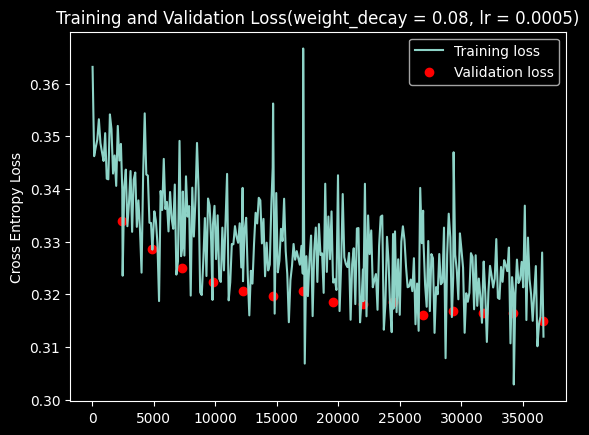

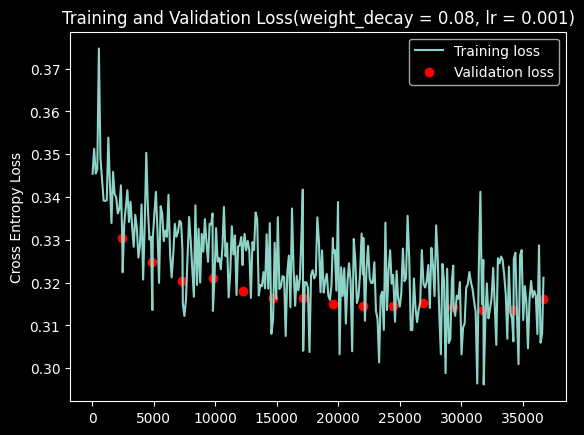

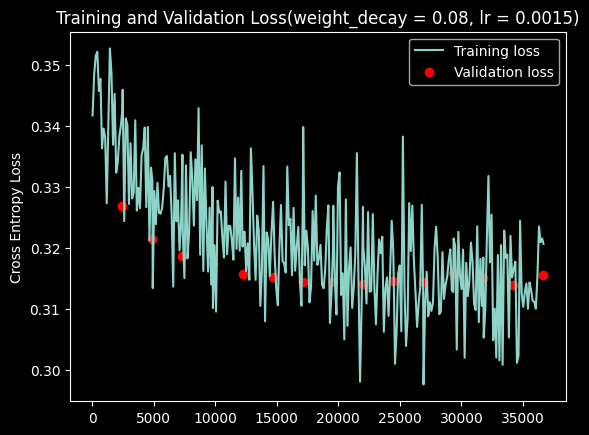

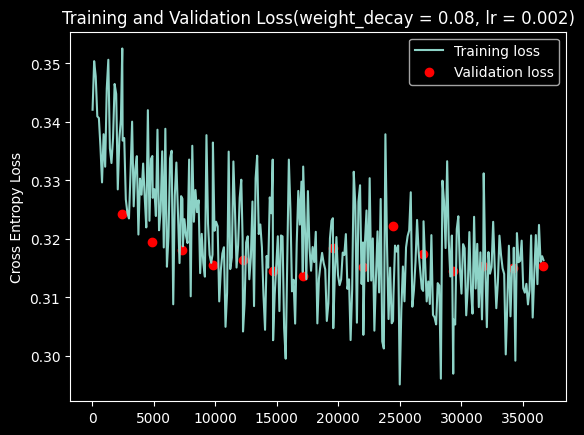

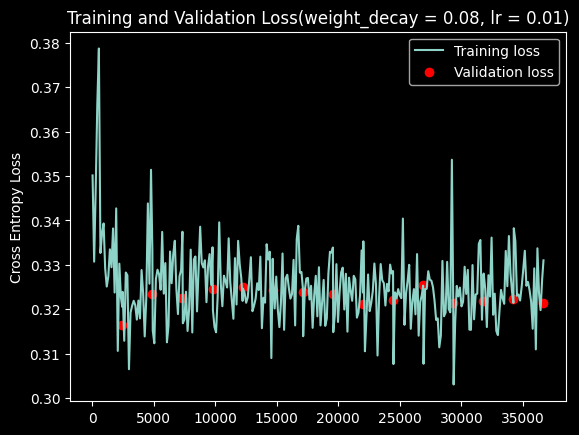

In [35]:
%matplotlib inline

# model = models.resnet18(pretrained=True)
# for param in model.parameters():   
#     param.requires_grad = False
# model.fc = nn.Sequential(
#     nn.Linear(model.fc.in_features, out_features=256, bias=True),
#     nn.ReLU(inplace=True),
#     nn.Dropout(p=0.5, inplace=False),
#     nn.Linear(in_features=256, out_features=2, bias=True),
#     nn.Softmax()
#     )



lr_rate = [0.0005, 0.001, 0.0015, 0.002, 0.01]
moment = 0.9
weight_dec = 0.08
num_of_epoch = 15
batch_size = 32
logging_period = 4
# criterion = nn.CrossEntropyLoss()
# optimizer =  optim.SGD(model.parameters(), lr=lr_rate, momentum=moment, weight_decay=weight_dec)

result_list = {}

for lr in lr_rate:

    model =  models.vgg16(pretrained=True)

    model.classifier[6] = nn.Sequential(
        nn.Linear(in_features = model.classifier[6].in_features, out_features = 2, bias = True),
        nn.Softmax(dim=1)
    )

    print('===================  Weight decay = {}, lr = {} ==================='.format(weight_dec, lr))    
    result_list[lr] = train( model, tr, val, batch_size, lr, moment, weight_dec, num_of_epoch, logging_period)

print(result_list)


c:\Users\kkomo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kkomo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/15 [00:00<?, ?it/s]

Epoch1 [0/2445 (0%)]	   avg.loss:0.3619   avg.accuracy:37.5000
Epoch1 [128/2445 (5%)]	   avg.loss:0.3496   avg.accuracy:51.5625
Epoch1 [256/2445 (10%)]	   avg.loss:0.3480   avg.accuracy:48.4375
Epoch1 [384/2445 (16%)]	   avg.loss:0.3493   avg.accuracy:52.3438
Epoch1 [512/2445 (21%)]	   avg.loss:0.3494   avg.accuracy:52.3438
Epoch1 [640/2445 (26%)]	   avg.loss:0.3389   avg.accuracy:57.0312
Epoch1 [768/2445 (31%)]	   avg.loss:0.3383   avg.accuracy:57.0312
Epoch1 [896/2445 (36%)]	   avg.loss:0.3420   avg.accuracy:56.2500
Epoch1 [1024/2445 (42%)]	   avg.loss:0.3478   avg.accuracy:52.3438
Epoch1 [1152/2445 (47%)]	   avg.loss:0.3452   avg.accuracy:49.2188
Epoch1 [1280/2445 (52%)]	   avg.loss:0.3414   avg.accuracy:54.6875
Epoch1 [1408/2445 (57%)]	   avg.loss:0.3421   avg.accuracy:57.8125
Epoch1 [1536/2445 (62%)]	   avg.loss:0.3423   avg.accuracy:57.0312
Epoch1 [1664/2445 (68%)]	   avg.loss:0.3254   avg.accuracy:66.4062
Epoch1 [1792/2445 (73%)]	   avg.loss:0.3444   avg.accuracy:53.1250
Epoch1 

  7%|▋         | 1/15 [01:01<14:25, 61.79s/it]


Validation set: avg.loss: 0.3318,   avg.accuracy: 370/612 (60.4575%)

Recall: 0.512195
Precision: 0.672000
F1 Score: 0.581315
Accuracy: 0.604575
Epoch2 [0/2445 (0%)]	   avg.loss:0.3375   avg.accuracy:53.1250
Epoch2 [128/2445 (5%)]	   avg.loss:0.3409   avg.accuracy:54.6875
Epoch2 [256/2445 (10%)]	   avg.loss:0.3306   avg.accuracy:61.7188
Epoch2 [384/2445 (16%)]	   avg.loss:0.3439   avg.accuracy:54.6875
Epoch2 [512/2445 (21%)]	   avg.loss:0.3186   avg.accuracy:64.8438
Epoch2 [640/2445 (26%)]	   avg.loss:0.3391   avg.accuracy:60.9375
Epoch2 [768/2445 (31%)]	   avg.loss:0.3212   avg.accuracy:69.5312
Epoch2 [896/2445 (36%)]	   avg.loss:0.3203   avg.accuracy:64.0625
Epoch2 [1024/2445 (42%)]	   avg.loss:0.3321   avg.accuracy:60.1562
Epoch2 [1152/2445 (47%)]	   avg.loss:0.3252   avg.accuracy:64.0625
Epoch2 [1280/2445 (52%)]	   avg.loss:0.3228   avg.accuracy:60.9375
Epoch2 [1408/2445 (57%)]	   avg.loss:0.3279   avg.accuracy:65.6250
Epoch2 [1536/2445 (62%)]	   avg.loss:0.3370   avg.accuracy:61.

 13%|█▎        | 2/15 [02:02<13:18, 61.40s/it]


Validation set: avg.loss: 0.3235,   avg.accuracy: 387/612 (63.2353%)

Recall: 0.661585
Precision: 0.655589
F1 Score: 0.658574
Accuracy: 0.632353
Epoch3 [0/2445 (0%)]	   avg.loss:0.3270   avg.accuracy:68.7500
Epoch3 [128/2445 (5%)]	   avg.loss:0.3337   avg.accuracy:57.0312
Epoch3 [256/2445 (10%)]	   avg.loss:0.3375   avg.accuracy:57.8125
Epoch3 [384/2445 (16%)]	   avg.loss:0.3208   avg.accuracy:67.9688
Epoch3 [512/2445 (21%)]	   avg.loss:0.3207   avg.accuracy:68.7500
Epoch3 [640/2445 (26%)]	   avg.loss:0.3224   avg.accuracy:65.6250
Epoch3 [768/2445 (31%)]	   avg.loss:0.3271   avg.accuracy:64.8438
Epoch3 [896/2445 (36%)]	   avg.loss:0.3408   avg.accuracy:54.6875
Epoch3 [1024/2445 (42%)]	   avg.loss:0.3322   avg.accuracy:54.6875
Epoch3 [1152/2445 (47%)]	   avg.loss:0.3330   avg.accuracy:62.5000
Epoch3 [1280/2445 (52%)]	   avg.loss:0.3404   avg.accuracy:59.3750
Epoch3 [1408/2445 (57%)]	   avg.loss:0.3413   avg.accuracy:53.9062
Epoch3 [1536/2445 (62%)]	   avg.loss:0.3127   avg.accuracy:71.

 20%|██        | 3/15 [03:04<12:17, 61.42s/it]


Validation set: avg.loss: 0.3210,   avg.accuracy: 398/612 (65.0327%)

Recall: 0.695122
Precision: 0.666667
F1 Score: 0.680597
Accuracy: 0.650327
Epoch4 [0/2445 (0%)]	   avg.loss:0.3571   avg.accuracy:46.8750
Epoch4 [128/2445 (5%)]	   avg.loss:0.3251   avg.accuracy:60.9375
Epoch4 [256/2445 (10%)]	   avg.loss:0.3285   avg.accuracy:59.3750
Epoch4 [384/2445 (16%)]	   avg.loss:0.3196   avg.accuracy:67.1875
Epoch4 [512/2445 (21%)]	   avg.loss:0.3268   avg.accuracy:64.0625
Epoch4 [640/2445 (26%)]	   avg.loss:0.3209   avg.accuracy:68.7500
Epoch4 [768/2445 (31%)]	   avg.loss:0.3494   avg.accuracy:52.3438
Epoch4 [896/2445 (36%)]	   avg.loss:0.3384   avg.accuracy:54.6875
Epoch4 [1024/2445 (42%)]	   avg.loss:0.3284   avg.accuracy:63.2812
Epoch4 [1152/2445 (47%)]	   avg.loss:0.3168   avg.accuracy:67.1875
Epoch4 [1280/2445 (52%)]	   avg.loss:0.3229   avg.accuracy:66.4062
Epoch4 [1408/2445 (57%)]	   avg.loss:0.3235   avg.accuracy:67.9688
Epoch4 [1536/2445 (62%)]	   avg.loss:0.3191   avg.accuracy:65.

 27%|██▋       | 4/15 [04:05<11:14, 61.29s/it]


Validation set: avg.loss: 0.3194,   avg.accuracy: 401/612 (65.5229%)

Recall: 0.710366
Precision: 0.667622
F1 Score: 0.688331
Accuracy: 0.655229
Epoch5 [0/2445 (0%)]	   avg.loss:0.3354   avg.accuracy:62.5000
Epoch5 [128/2445 (5%)]	   avg.loss:0.3254   avg.accuracy:65.6250
Epoch5 [256/2445 (10%)]	   avg.loss:0.3259   avg.accuracy:60.1562
Epoch5 [384/2445 (16%)]	   avg.loss:0.3138   avg.accuracy:68.7500
Epoch5 [512/2445 (21%)]	   avg.loss:0.3187   avg.accuracy:69.5312
Epoch5 [640/2445 (26%)]	   avg.loss:0.3234   avg.accuracy:59.3750
Epoch5 [768/2445 (31%)]	   avg.loss:0.3086   avg.accuracy:70.3125
Epoch5 [896/2445 (36%)]	   avg.loss:0.3178   avg.accuracy:67.9688
Epoch5 [1024/2445 (42%)]	   avg.loss:0.3177   avg.accuracy:60.9375
Epoch5 [1152/2445 (47%)]	   avg.loss:0.3465   avg.accuracy:53.1250
Epoch5 [1280/2445 (52%)]	   avg.loss:0.3284   avg.accuracy:62.5000
Epoch5 [1408/2445 (57%)]	   avg.loss:0.3198   avg.accuracy:66.4062
Epoch5 [1536/2445 (62%)]	   avg.loss:0.3314   avg.accuracy:63.

 33%|███▎      | 5/15 [05:07<10:14, 61.47s/it]


Validation set: avg.loss: 0.3181,   avg.accuracy: 403/612 (65.8497%)

Recall: 0.734756
Precision: 0.663912
F1 Score: 0.697540
Accuracy: 0.658497
Epoch6 [0/2445 (0%)]	   avg.loss:0.3363   avg.accuracy:62.5000
Epoch6 [128/2445 (5%)]	   avg.loss:0.3371   avg.accuracy:58.5938
Epoch6 [256/2445 (10%)]	   avg.loss:0.3235   avg.accuracy:63.2812
Epoch6 [384/2445 (16%)]	   avg.loss:0.3260   avg.accuracy:63.2812
Epoch6 [512/2445 (21%)]	   avg.loss:0.3313   avg.accuracy:61.7188
Epoch6 [640/2445 (26%)]	   avg.loss:0.3246   avg.accuracy:62.5000
Epoch6 [768/2445 (31%)]	   avg.loss:0.3216   avg.accuracy:60.1562
Epoch6 [896/2445 (36%)]	   avg.loss:0.3286   avg.accuracy:65.6250
Epoch6 [1024/2445 (42%)]	   avg.loss:0.3302   avg.accuracy:60.1562
Epoch6 [1152/2445 (47%)]	   avg.loss:0.3320   avg.accuracy:64.0625
Epoch6 [1280/2445 (52%)]	   avg.loss:0.3246   avg.accuracy:67.9688
Epoch6 [1408/2445 (57%)]	   avg.loss:0.3266   avg.accuracy:63.2812
Epoch6 [1536/2445 (62%)]	   avg.loss:0.3045   avg.accuracy:75.

 40%|████      | 6/15 [06:07<09:09, 61.04s/it]


Validation set: avg.loss: 0.3177,   avg.accuracy: 403/612 (65.8497%)

Recall: 0.685976
Precision: 0.679758
F1 Score: 0.682853
Accuracy: 0.658497
Epoch7 [0/2445 (0%)]	   avg.loss:0.3335   avg.accuracy:59.3750
Epoch7 [128/2445 (5%)]	   avg.loss:0.3361   avg.accuracy:55.4688
Epoch7 [256/2445 (10%)]	   avg.loss:0.3200   avg.accuracy:68.7500
Epoch7 [384/2445 (16%)]	   avg.loss:0.3189   avg.accuracy:64.0625
Epoch7 [512/2445 (21%)]	   avg.loss:0.3063   avg.accuracy:74.2188
Epoch7 [640/2445 (26%)]	   avg.loss:0.3172   avg.accuracy:67.9688
Epoch7 [768/2445 (31%)]	   avg.loss:0.3275   avg.accuracy:64.0625
Epoch7 [896/2445 (36%)]	   avg.loss:0.3252   avg.accuracy:67.1875
Epoch7 [1024/2445 (42%)]	   avg.loss:0.3226   avg.accuracy:62.5000
Epoch7 [1152/2445 (47%)]	   avg.loss:0.3215   avg.accuracy:66.4062
Epoch7 [1280/2445 (52%)]	   avg.loss:0.3262   avg.accuracy:64.8438
Epoch7 [1408/2445 (57%)]	   avg.loss:0.3266   avg.accuracy:63.2812
Epoch7 [1536/2445 (62%)]	   avg.loss:0.3164   avg.accuracy:69.

 47%|████▋     | 7/15 [07:10<08:13, 61.74s/it]


Validation set: avg.loss: 0.3174,   avg.accuracy: 406/612 (66.3399%)

Recall: 0.667683
Precision: 0.693038
F1 Score: 0.680124
Accuracy: 0.663399
Epoch8 [0/2445 (0%)]	   avg.loss:0.3471   avg.accuracy:53.1250
Epoch8 [128/2445 (5%)]	   avg.loss:0.3207   avg.accuracy:67.1875
Epoch8 [256/2445 (10%)]	   avg.loss:0.3200   avg.accuracy:68.7500
Epoch8 [384/2445 (16%)]	   avg.loss:0.3172   avg.accuracy:69.5312
Epoch8 [512/2445 (21%)]	   avg.loss:0.3153   avg.accuracy:68.7500
Epoch8 [640/2445 (26%)]	   avg.loss:0.3306   avg.accuracy:62.5000
Epoch8 [768/2445 (31%)]	   avg.loss:0.3253   avg.accuracy:60.9375
Epoch8 [896/2445 (36%)]	   avg.loss:0.3145   avg.accuracy:69.5312
Epoch8 [1024/2445 (42%)]	   avg.loss:0.3175   avg.accuracy:67.1875
Epoch8 [1152/2445 (47%)]	   avg.loss:0.3191   avg.accuracy:70.3125
Epoch8 [1280/2445 (52%)]	   avg.loss:0.3082   avg.accuracy:75.7812
Epoch8 [1408/2445 (57%)]	   avg.loss:0.3259   avg.accuracy:61.7188
Epoch8 [1536/2445 (62%)]	   avg.loss:0.3066   avg.accuracy:76.

 53%|█████▎    | 8/15 [14:32<21:19, 182.84s/it]


Validation set: avg.loss: 0.3159,   avg.accuracy: 403/612 (65.8497%)

Recall: 0.689024
Precision: 0.678679
F1 Score: 0.683812
Accuracy: 0.658497
Epoch9 [0/2445 (0%)]	   avg.loss:0.3302   avg.accuracy:56.2500
Epoch9 [128/2445 (5%)]	   avg.loss:0.3280   avg.accuracy:64.8438
Epoch9 [256/2445 (10%)]	   avg.loss:0.3167   avg.accuracy:70.3125
Epoch9 [384/2445 (16%)]	   avg.loss:0.3337   avg.accuracy:61.7188
Epoch9 [512/2445 (21%)]	   avg.loss:0.3180   avg.accuracy:68.7500
Epoch9 [640/2445 (26%)]	   avg.loss:0.3290   avg.accuracy:60.1562
Epoch9 [768/2445 (31%)]	   avg.loss:0.3319   avg.accuracy:55.4688
Epoch9 [896/2445 (36%)]	   avg.loss:0.3154   avg.accuracy:67.9688
Epoch9 [1024/2445 (42%)]	   avg.loss:0.3236   avg.accuracy:66.4062
Epoch9 [1152/2445 (47%)]	   avg.loss:0.3145   avg.accuracy:66.4062
Epoch9 [1280/2445 (52%)]	   avg.loss:0.3153   avg.accuracy:67.9688
Epoch9 [1408/2445 (57%)]	   avg.loss:0.3276   avg.accuracy:59.3750
Epoch9 [1536/2445 (62%)]	   avg.loss:0.3140   avg.accuracy:67.

 60%|██████    | 9/15 [39:49<59:59, 599.89s/it]


Validation set: avg.loss: 0.3163,   avg.accuracy: 407/612 (66.5033%)

Recall: 0.661585
Precision: 0.697749
F1 Score: 0.679186
Accuracy: 0.665033
Epoch10 [0/2445 (0%)]	   avg.loss:0.3178   avg.accuracy:68.7500
Epoch10 [128/2445 (5%)]	   avg.loss:0.3309   avg.accuracy:59.3750
Epoch10 [256/2445 (10%)]	   avg.loss:0.3179   avg.accuracy:66.4062
Epoch10 [384/2445 (16%)]	   avg.loss:0.3308   avg.accuracy:61.7188
Epoch10 [512/2445 (21%)]	   avg.loss:0.3178   avg.accuracy:67.1875
Epoch10 [640/2445 (26%)]	   avg.loss:0.3205   avg.accuracy:64.8438
Epoch10 [768/2445 (31%)]	   avg.loss:0.3245   avg.accuracy:63.2812
Epoch10 [896/2445 (36%)]	   avg.loss:0.3327   avg.accuracy:55.4688
Epoch10 [1024/2445 (42%)]	   avg.loss:0.3153   avg.accuracy:70.3125
Epoch10 [1152/2445 (47%)]	   avg.loss:0.3196   avg.accuracy:66.4062
Epoch10 [1280/2445 (52%)]	   avg.loss:0.3176   avg.accuracy:69.5312
Epoch10 [1408/2445 (57%)]	   avg.loss:0.3193   avg.accuracy:64.8438
Epoch10 [1536/2445 (62%)]	   avg.loss:0.3330   avg

 67%|██████▋   | 10/15 [40:39<35:50, 430.03s/it]


Validation set: avg.loss: 0.3143,   avg.accuracy: 405/612 (66.1765%)

Recall: 0.737805
Precision: 0.666667
F1 Score: 0.700434
Accuracy: 0.661765
Epoch11 [0/2445 (0%)]	   avg.loss:0.3431   avg.accuracy:56.2500
Epoch11 [128/2445 (5%)]	   avg.loss:0.3149   avg.accuracy:71.8750
Epoch11 [256/2445 (10%)]	   avg.loss:0.3233   avg.accuracy:60.1562
Epoch11 [384/2445 (16%)]	   avg.loss:0.3148   avg.accuracy:65.6250
Epoch11 [512/2445 (21%)]	   avg.loss:0.3282   avg.accuracy:61.7188
Epoch11 [640/2445 (26%)]	   avg.loss:0.3117   avg.accuracy:67.1875
Epoch11 [768/2445 (31%)]	   avg.loss:0.3148   avg.accuracy:66.4062
Epoch11 [896/2445 (36%)]	   avg.loss:0.3159   avg.accuracy:69.5312
Epoch11 [1024/2445 (42%)]	   avg.loss:0.3206   avg.accuracy:65.6250
Epoch11 [1152/2445 (47%)]	   avg.loss:0.3212   avg.accuracy:66.4062
Epoch11 [1280/2445 (52%)]	   avg.loss:0.3192   avg.accuracy:66.4062
Epoch11 [1408/2445 (57%)]	   avg.loss:0.3282   avg.accuracy:64.8438
Epoch11 [1536/2445 (62%)]	   avg.loss:0.3176   avg

 73%|███████▎  | 11/15 [41:19<20:43, 310.85s/it]


Validation set: avg.loss: 0.3155,   avg.accuracy: 409/612 (66.8301%)

Recall: 0.646341
Precision: 0.709030
F1 Score: 0.676236
Accuracy: 0.668301
Epoch12 [0/2445 (0%)]	   avg.loss:0.3235   avg.accuracy:68.7500
Epoch12 [128/2445 (5%)]	   avg.loss:0.3173   avg.accuracy:66.4062
Epoch12 [256/2445 (10%)]	   avg.loss:0.3142   avg.accuracy:68.7500
Epoch12 [384/2445 (16%)]	   avg.loss:0.3259   avg.accuracy:64.8438
Epoch12 [512/2445 (21%)]	   avg.loss:0.3216   avg.accuracy:60.9375
Epoch12 [640/2445 (26%)]	   avg.loss:0.3279   avg.accuracy:60.9375
Epoch12 [768/2445 (31%)]	   avg.loss:0.3208   avg.accuracy:63.2812
Epoch12 [896/2445 (36%)]	   avg.loss:0.3165   avg.accuracy:67.9688
Epoch12 [1024/2445 (42%)]	   avg.loss:0.3147   avg.accuracy:67.9688
Epoch12 [1152/2445 (47%)]	   avg.loss:0.3076   avg.accuracy:71.0938
Epoch12 [1280/2445 (52%)]	   avg.loss:0.3259   avg.accuracy:65.6250
Epoch12 [1408/2445 (57%)]	   avg.loss:0.3190   avg.accuracy:67.9688
Epoch12 [1536/2445 (62%)]	   avg.loss:0.3202   avg

 80%|████████  | 12/15 [41:59<11:24, 228.17s/it]


Validation set: avg.loss: 0.3139,   avg.accuracy: 413/612 (67.4837%)

Recall: 0.689024
Precision: 0.699690
F1 Score: 0.694316
Accuracy: 0.674837
Epoch13 [0/2445 (0%)]	   avg.loss:0.3202   avg.accuracy:65.6250
Epoch13 [128/2445 (5%)]	   avg.loss:0.3171   avg.accuracy:66.4062
Epoch13 [256/2445 (10%)]	   avg.loss:0.3169   avg.accuracy:66.4062
Epoch13 [384/2445 (16%)]	   avg.loss:0.3237   avg.accuracy:62.5000
Epoch13 [512/2445 (21%)]	   avg.loss:0.3189   avg.accuracy:62.5000
Epoch13 [640/2445 (26%)]	   avg.loss:0.3217   avg.accuracy:65.6250
Epoch13 [768/2445 (31%)]	   avg.loss:0.3129   avg.accuracy:69.5312
Epoch13 [896/2445 (36%)]	   avg.loss:0.3020   avg.accuracy:71.8750
Epoch13 [1024/2445 (42%)]	   avg.loss:0.3224   avg.accuracy:64.8438
Epoch13 [1152/2445 (47%)]	   avg.loss:0.3198   avg.accuracy:63.2812
Epoch13 [1280/2445 (52%)]	   avg.loss:0.3170   avg.accuracy:67.1875
Epoch13 [1408/2445 (57%)]	   avg.loss:0.3214   avg.accuracy:62.5000
Epoch13 [1536/2445 (62%)]	   avg.loss:0.3123   avg

 87%|████████▋ | 13/15 [42:38<05:42, 171.07s/it]


Validation set: avg.loss: 0.3171,   avg.accuracy: 405/612 (66.1765%)

Recall: 0.576220
Precision: 0.735409
F1 Score: 0.646154
Accuracy: 0.661765
Epoch14 [0/2445 (0%)]	   avg.loss:0.3504   avg.accuracy:56.2500
Epoch14 [128/2445 (5%)]	   avg.loss:0.3094   avg.accuracy:70.3125
Epoch14 [256/2445 (10%)]	   avg.loss:0.3274   avg.accuracy:61.7188
Epoch14 [384/2445 (16%)]	   avg.loss:0.3074   avg.accuracy:68.7500
Epoch14 [512/2445 (21%)]	   avg.loss:0.3171   avg.accuracy:65.6250
Epoch14 [640/2445 (26%)]	   avg.loss:0.3367   avg.accuracy:59.3750
Epoch14 [768/2445 (31%)]	   avg.loss:0.3158   avg.accuracy:67.1875
Epoch14 [896/2445 (36%)]	   avg.loss:0.3264   avg.accuracy:61.7188
Epoch14 [1024/2445 (42%)]	   avg.loss:0.3176   avg.accuracy:65.6250
Epoch14 [1152/2445 (47%)]	   avg.loss:0.3176   avg.accuracy:65.6250
Epoch14 [1280/2445 (52%)]	   avg.loss:0.3057   avg.accuracy:75.7812
Epoch14 [1408/2445 (57%)]	   avg.loss:0.3174   avg.accuracy:66.4062
Epoch14 [1536/2445 (62%)]	   avg.loss:0.3060   avg

 93%|█████████▎| 14/15 [43:17<02:11, 131.12s/it]


Validation set: avg.loss: 0.3133,   avg.accuracy: 416/612 (67.9739%)

Recall: 0.710366
Precision: 0.697605
F1 Score: 0.703927
Accuracy: 0.679739
Epoch15 [0/2445 (0%)]	   avg.loss:0.3169   avg.accuracy:68.7500
Epoch15 [128/2445 (5%)]	   avg.loss:0.3279   avg.accuracy:62.5000
Epoch15 [256/2445 (10%)]	   avg.loss:0.3047   avg.accuracy:70.3125
Epoch15 [384/2445 (16%)]	   avg.loss:0.3071   avg.accuracy:71.0938
Epoch15 [512/2445 (21%)]	   avg.loss:0.3122   avg.accuracy:68.7500
Epoch15 [640/2445 (26%)]	   avg.loss:0.3041   avg.accuracy:75.0000
Epoch15 [768/2445 (31%)]	   avg.loss:0.3119   avg.accuracy:67.9688
Epoch15 [896/2445 (36%)]	   avg.loss:0.3064   avg.accuracy:71.0938
Epoch15 [1024/2445 (42%)]	   avg.loss:0.3115   avg.accuracy:69.5312
Epoch15 [1152/2445 (47%)]	   avg.loss:0.3124   avg.accuracy:71.8750
Epoch15 [1280/2445 (52%)]	   avg.loss:0.3147   avg.accuracy:66.4062
Epoch15 [1408/2445 (57%)]	   avg.loss:0.3145   avg.accuracy:67.1875
Epoch15 [1536/2445 (62%)]	   avg.loss:0.3112   avg

100%|██████████| 15/15 [43:56<00:00, 175.77s/it]


Validation set: avg.loss: 0.3130,   avg.accuracy: 414/612 (67.6471%)

Recall: 0.722561
Precision: 0.688953
F1 Score: 0.705357
Accuracy: 0.676471



C:\Users\kkomo\AppData\Local\Temp\ipykernel_36424\3978523012.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


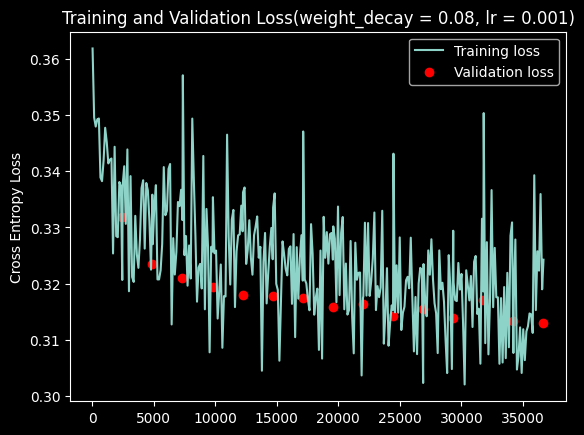

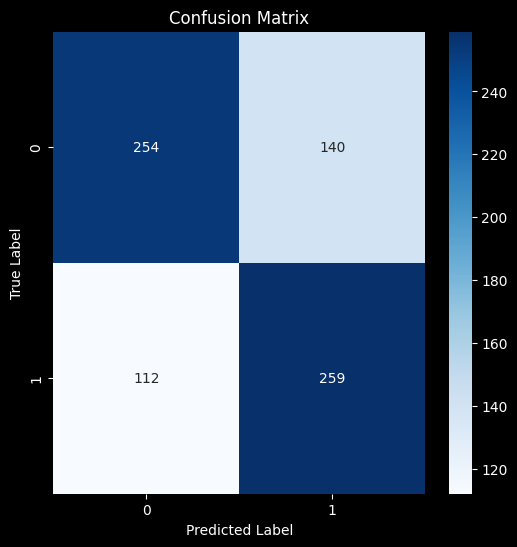

Recall: 0.6981
Precision: 0.6491
F1 Score: 0.6727
Accuracy: 0.6706


In [50]:
# Again, train the model with best hyper parameters (Weight decay = 0.08, lr = 0.001)
lr_rate = 0.001
moment = 0.9
weight_dec = 0.08
num_of_epoch = 15
batch_size = 32
logging_period = 4

model =  models.vgg16(pretrained=True)

model.classifier[6] = nn.Sequential(
    nn.Linear(in_features = model.classifier[6].in_features, out_features = 2, bias = True),
    nn.Softmax(dim=1)
)

train(model, tr, val, batch_size, lr_rate, moment, weight_dec, num_of_epoch, logging_period)

# Test the model with the best hyper parameters
test(model, ts, batch_size)


# Result archiving

## Testing with test dataset

![Alt text](image-103.png)

![Alt text](image-104.png)


lr_rate = 0.001
moment = 0.9
weight_dec = 0.08
num_of_epoch = 15
batch_size = 32
logging_period = 4

- Recall: 0.6981
Precision: 0.6491
F1 Score: 0.6727
Accuracy: 0.6706

## Hyper parameter tuning for learning rate

lr_rate = [0.0005, 0.001, 0.0015, 0.002, 0.01]
moment = 0.9
weight_dec = 0.08
num_of_epoch = 15
batch_size = 32
logging_period = 4

## ![Alt text](image-105.png)
- Recall: 0.672474
Precision: 0.639073
F1 Score: 0.655348
Accuracy: 0.668301

## ![Alt text](image-106.png)
- Recall: 0.749129
Precision: 0.626822
F1 Score: 0.682540
Accuracy: 0.673203

## ![Alt text](image-107.png)
- Recall: 0.689895
Precision: 0.636656
F1 Score: 0.662207
Accuracy: 0.669935

## ![Alt text](image-108.png)
- Recall: 0.644599
Precision: 0.675182
F1 Score: 0.659537
Accuracy: 0.687908

## ![Alt text](image-109.png)
- Recall: 0.665505
Precision: 0.636667
F1 Score: 0.650767
Accuracy: 0.665033

{0.0005: 0.6553480475382004, 0.001: 0.6825396825396826, 0.0015: 0.6622073578595317, 0.002: 0.6595365418894831, 0.01: 0.6507666098807495}


## Hyper parameter tuning for weight decay

lr_rate = 0.001
moment = 0.9
weight_dec = [0.06, 0.08, 0.10, 0.12]
num_of_epoch = 15
batch_size = 32
logging_period = 8

## ![Alt text](image-96.png) 
- Recall: 0.612805
Precision: 0.736264
F1 Score: 0.668885
Accuracy: 0.674837

## ![Alt text](image-97.png)
- Recall: 0.685976
Precision: 0.716561
F1 Score: 0.700935
Accuracy: 0.686275

## ![Alt text](image-98.png)
- Recall: 0.655488
Precision: 0.733788
F1 Score: 0.692432
Accuracy: 0.687908

## ![Alt text](image-99.png)
- Recall: 0.673780
Precision: 0.706070
F1 Score: 0.689548
Accuracy: 0.674837

{0.06: 0.6688851913477537, 0.08: 0.7009345794392523, 0.1: 0.6924315619967794, 0.12: 0.6895475819032761}